In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from operator import add
import tomotopy as tp
import pandas as pd
import numpy as np
import string
import nltk
import sys
import os
import re

In [2]:
%matplotlib inline

In [3]:
print( "Good to go!" if (nltk.download("stopwords") and 
                         nltk.download('wordnet') and 
                         nltk.download('averaged_perceptron_tagger') and
                         nltk.download('punkt')) else "Error downloading requirements")

Good to go!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\denis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\denis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\denis\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\denis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# <center> Reading Diagonally </center>
<center>By Denis Zahariev</center>

Download this notebook from: TODO

<br>
<br>
<center style="font-size: 22px"><strong>Abstract</strong></center>
<br>
<center>How can a single person understand what is going on in a collection of millions of documents? 
<br>This is an increasingly common problem: scrolling through an organization’s e-mails, understanding a decade worth of newspapers, or characterizing a scientific field’s research. This and other similar questions are the problem that Natural Language Processing (<strong>NLP</strong>) is searching answers for. While that abbreviation sums up many sub-categories, in this paper we are going to explore data preparation and topic modeling with 2 Machine Learning models with objective of  demonstrating the topic distribution of various documents at the end.</center>

### Table of contents:
1. [Introduction](#introduction)
    1. [What is a Topic model?](#What_is_a_Topic_model?)
    2. [What is LDA?](#What_is_LDA?)
    3. [What is PAM?](#What_is_PAM?)
        1. [What is Directed Acyclic Graph?](#What_is_Directed_Acyclic_Graph?)
<br>
<br>
2. [Exploring our data](#Exploring_our_data)
    1. [Exploring the DF dataset](#Exploring_the_DF_dataset)
        1. [Reading the dataset](#Reading_the_dataset_df)
        2. [Data tidying and cleaning](#Data_tidying_and_cleaning_df)
        3. [Stemming vs Lemmatization](#Stemming_vs_Lemmatization)
    2. [Exploring the TM dataset](#Exploring_the_TM_dataset)
        1. [Reading the dataset](#Reading_the_dataset_tm)
        2. [Data tidying and cleaning](#Data_tidying_and_cleaning_tm)
    3. [Content comparison](#Content_comparison)
<br>
<br>
3. [Latent Dirichlet Allocation](#LDA)
    1. [Assumptions](#Assumptions_LDA)
    2. [Preparing our data](#Preparing_our_data_LDA)
    3. [Implementation](#Implementation_LDA)
    4. [Gibbs Sampling](#Gibbs_Sampling)
    5. [Application](#Applications)
<br>
<br>   
4. [Pachinko Allocation Model](#PAM)
    1. [Assumptions](#Assumptions_PAM)
    2. [Preparing our data](#Preparing_our_data_PAM)
    3. [Example](#Example_PAM)
<br>
<br>  
5. [Model Comparisson](#Model_Comparisson)
    1. [Performance](#Performance)
    2. [Accuracy](#Accuracy)
<br>
<br> 
6. [Conclusion](#Conclusion)
   

# <div class="alert alert-block alert-info">1. Introduction </div> <a class="anchor" id="introduction"></a>

## 1.A What is a Topic model? <a class="anchor" id="introduction"></a>

In Machine Learning(__ML__) and __NLP__, a topic model is a type of statistical model, usually __unsupervised__, for discovering the abstract "topics" that occur in a collection of documents. Unsupervised classification is such one that doesn't require human help to train itself. to Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body or in a collection of texts. 

In a practical and more intuitively, you can think of it as a task of:
<br><br>
* __Dimensionality Reduction__, where rather than representing a text T in its feature space as 
```python 
{Word_i: count(Word_i, T) for Word_i in Vocabulary}
```
, you can represent it in a topic space as 
```python 
{Topic_i: Weight(Topic_i, T) for Topic_i in Topics}
```

Intuitively, given that a document is about a particular topic, one would expect particular words to appear in the document more or less frequently: "dog" and "bone" will appear more often in documents about dogs, "cat" and "meow" will appear in documents about cats, and "the" and "is" will appear approximately equally in both.


* __Unsupervised Learning__, where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight


* __Tagging__, abstract “topics” that occur in a collection of documents that best represents the information in them.
There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)
In this paper, we’ll take a closer look at LDA, and implement our first topic model using the sklearn implementation in python 2.7

## 1.B What is LDA? <a class="anchor" id="What_is_LDA"></a>

Latent Dirichlet Allocation (__LDA__) model is a generative statisitcal model of a collection of documents. The idea is that documents are represented as random mixtures over latent topics, where each topic is characterized by a distribution over words. The idea behind LDA in one sentence is that
<br>
<br>
<center><i>Each document can be described by a distribution of topics and each topic can be described by a distribution of words.</i></center>

## 1.B What is PAM? <a class="anchor" id="What_is_PAM"></a>


The Pachinko Allocation Model (__PAM__) is yet another of the many topic models, but this one is invented to fix a huge limitation of the LDA method. 
<br>
<br>
It captures arbitrary, nested and sparse correlations between topics using Directed Acyclic Graph (__DAG__). The algorithm improves upon earlier topic models, including Latent Dirichlet allocation (LDA) by modeling correlations between topics in addition to the word correlations which constitute topics. The list of all words obtained from the corpus after removing the stopwords and text processing represents the dirichlet distribution.  __PAM__ provides more flexibility and greater expressive power than the Latent Dirichlet Allocation. While first described and implemented in the context of natural language processing, the algorithm has applications in other fields like bioinformatics.
<br>
<br>
The model is named after a popular game in Japan - Pachinko, in which metal balls bounce down around a complex collection of pins until they land in various bins at the bottom.

### What is Directed Acyclic Graph? <a class="anchor" id="What_is_Directed_Acyclic_Graph?"></a>

In a PAM, each of the topic generated is associated with the dirichlet distribution through a Directed Acyclic Graph.
<br>

A graph in Computer Science represents a network that contains __nodes__ and __edges__ between them:

<center>
    <figure>
        <img src = https://cs.slu.edu/~esposito/teaching/1080/webscience/images/6nodes-graph.jpg></img>
    <figcaption><strong>Graph Example</strong></figcaption>
</figure></center>

### Characteristics

<u>__Graphs can be directed and undirected.__</u>
<br><br>
The edges or __links__ between nodes can be oriented or not.

<center>
    <figure>
        <img src = https://s3.ap-south-1.amazonaws.com/s3.studytonight.com/tutorials/uploads/pictures/1601571315-76844.png alt="Undirected graph"></img>
    <figcaption><strong>Undirected graph</strong></figcaption>
    </figure>
</center>
<br>
<br>
When the links are directed, they are only "visible" in the direction they are oriented. However, nothing stops us from having two back oriented links between two nodes, in this case the link can be treated as undirected.

<center>
    <figure>
        <img src = https://s3.ap-south-1.amazonaws.com/s3.studytonight.com/tutorials/uploads/pictures/1601571633-76844.png alt="Directed graph"></img>
        <figcaption><strong>Directed graph</strong></figcaption>
    </figure>
</center>



<u>__Graphs can be cyclic and acyclic.__</u>
<br><br>
In the context of directed graphs, a __cyclic__ graph contains atleast 1 __graph cycle__.

<center>
    <figure>
        <img src = https://s3.ap-south-1.amazonaws.com/s3.studytonight.com/tutorials/uploads/pictures/1601573458-76844.png alt="Cyclic graph"></img>
    <figcaption><strong>Cyclic graph</strong></figcaption>
    </figure>
</center>
<br>
<br>

<center>
    <figure>
        <img src = https://s3.ap-south-1.amazonaws.com/s3.studytonight.com/tutorials/uploads/pictures/1601575738-76844.png alt="Directed graph"></img>
        <figcaption><strong>Acyclic graph</strong></figcaption>
    </figure>
</center>

<u>__Graphs can be weighted.__</u>
<br><br>
Both undirected and directed graphs' edges can be weighted.
<center>
    <figure>
        <img src = https://s3.ap-south-1.amazonaws.com/s3.studytonight.com/tutorials/uploads/pictures/1601622376-76844.png alt="Cyclic graph"></img>
    <figcaption><strong>Weighted graph</strong></figcaption>
    </figure>
</center>
<br>
<br>

This concept takes place in all maps, navigations and many pathfinding algorithms. It is threated like a __cost__ of moving through that edge or a coefficient. 
<br>
For this notebook, we will not need the whole theory around graphs. For the ones who are willing to learn the rest, there is a good online article <a href="https://www.studytonight.com/advanced-data-structures/introduction-to-graphs">here</a>.

# <div class="alert alert-block alert-info">2. Exploring our data </div> <a class="anchor" id="Exploring_our_data"></a>

For this project I have chosen 2 datasets containing research articles and topics. Both have been used in different hackatons recently. The first dataset, used in HackLive 3 and can be found <a href="https://www.kaggle.com/anmolkumar/topic-modeling-for-research-articles-20/tasks?taskId=2470">here</a>. In the code below it has a prefix `df`. The second dataset, later used with prefix `tm`, has been presented in Janatahack, inspired by the global pandemic. You can find it <a href="https://www.kaggle.com/blessondensil294/topic-modeling-for-research-articles">here</a>.
<br>
<br>
Those datasets have been chosen for several reasons. They are very suitable for topic modeling and provide domain-oriented topics, which raises the bar for models that need to distinguish the hidden topics and for us, respectively, to train them. Originally they come in pairs of training dataset and testing dataset. Later we will exclude 2 of them and explain why each of them is not suitable for this paper and how we are going to get around that.

## 2.1 Exploring the DF dataset <a class="anchor" id="Exploring_the_DF_dataset "></a>

### 2.1.A Reading the dataset <a class="anchor" id="Reading_the_dataset_df"></a>

In [4]:
df_train = pd.read_csv("Datasets\\research-articles\\train.csv")
df_test = pd.read_csv("Datasets\\research-articles\\test.csv")

In [5]:
df_test.head()

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics
0,9409,fundamental frequency (f0) approximation from ...,0,0,0,1
1,17934,"this large-scale study, consisting of 24.5 mil...",1,0,0,1
2,16071,we present a stability analysis of the plane c...,0,0,1,0
3,16870,we construct finite time blow-up solutions to ...,0,1,0,0
4,10496,planetary nebulae (pne) constitute an importan...,0,0,1,0


In [6]:
df_train.head()

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2082,stars are self-gravitating fluids inside which...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8687,deep neural perception and control networks ar...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.1.B Data tidying and cleaning <a class="anchor" id="Data_tidying_and_cleaning_df"></a>

The IDs included in the dataset won't be easy to iterate so we remove them.

In [7]:
df_train = df_train.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)

We see that 1 of the articles contains not 1 but 2 topics - Computer Science and Statistics. Lets see how many are like this.

In [8]:
df_test[df_test[df_test.columns.tolist()[1:]].sum(axis=1)>1]

,ABSTRACT,Computer Science,Mathematics,Physics,Statistics
1,"this large-scale study, consisting of 24.5 mil...",1,0,0,1
8,we study a problem of community detection insi...,1,1,0,1
21,this paper proposes the convolutional neural n...,1,0,0,1
22,"inside this paper, we consider a usual linear ...",0,1,0,1
27,superconductivity has been a focus of enormous...,0,0,1,1
...,...,...,...,...,...
5937,millimeter-wave (mmwave) communication operate...,1,1,0,0
5954,recurrent neural networks (rnns) are now widel...,1,0,0,1
5965,supervisory signals have a potential to make l...,1,0,0,1
5967,we present an idea behind the method consideri...,1,0,0,1


In [9]:
df_train[df_train[df_train.columns.tolist()[1:]].sum(axis=1)>1]

,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,stars are self-gravitating fluids inside which...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,deep neural perception and control networks ar...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13999,a methodology of automatic detection of a even...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
14000,we consider a case inside which the robot has ...,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
14001,despite being usually considered two competing...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
14002,we present the framework and its implementatio...,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


It's not that this is illegal but could mess up our models later on by bringing this "multitopicness" to other documents. That is why we will exclude them from the dataset.
<br>
<br>
The problem with the training dataset is that this is actually the whole dataset. 14004/14004

Inside the training dataset there are 14004 samples, which is shown by the code below:

In [10]:
df_train.shape

(14004, 30)

Leaving them with one topic at random won't be helpful either since what we need are the words. For this reason we are not going to work with the training part of this dataset.

In [11]:
def remove_multitopics(dataframe, spacing):
    """
    Removes records from `dataframe` that match to more than 1 topic
    and returns new dataframe
    """
    return dataframe.drop(dataframe[dataframe[dataframe.columns.tolist()[spacing:]].sum(axis=1)>1].index)

In [12]:
df_test = remove_multitopics(df_test,1)

We can do the same to see the test dataset:

In [13]:
df_test.shape

(5042, 5)

Also, with the ```info()``` method, we can see that all our topics are represented by integer numbers.

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   ABSTRACT                                      14004 non-null  object
 1   Computer Science                              14004 non-null  int64 
 2   Mathematics                                   14004 non-null  int64 
 3   Physics                                       14004 non-null  int64 
 4   Statistics                                    14004 non-null  int64 
 5   Analysis of PDEs                              14004 non-null  int64 
 6   Applications                                  14004 non-null  int64 
 7   Artificial Intelligence                       14004 non-null  int64 
 8   Astrophysics of Galaxies                      14004 non-null  int64 
 9   Computation and Language                      14004 non-null  int64 
 10

In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5042 entries, 0 to 6001
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ABSTRACT          5042 non-null   object
 1   Computer Science  5042 non-null   int64 
 2   Mathematics       5042 non-null   int64 
 3   Physics           5042 non-null   int64 
 4   Statistics        5042 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 236.3+ KB


 Since both LDA and PAM are unsupervised learning models and dont't work with the actual topic names, we will not need anything more than their total count to get results.

In [16]:
def get_topics_and_count(dataframe, spacing):
    """
    Returns tuple consisting of a list of the topics inside `dataframe`
    by skipping N=`spacing` columns
    """
    output = dataframe.columns.tolist()[spacing:]
    return output, len(output)

In [17]:
test_topics, test_topics_count = get_topics_and_count(df_test, 1)

In [18]:
test_topics_count

4

If we look at the column topics, we will find that they seem to tend to be either 1 or 0. Lets confirm if that is true.

In [19]:
[df_test[x].unique() for x in test_topics]

[array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([1, 0], dtype=int64)]

Since those columns are categorical values, we can transform them to be.

By excluding the multitopic records we are able to dump all the topic information into one categorical column.

Lets write a function that will return a list that we will use to create the new column. The new value inside won't be a tag but a topic ID.

In [20]:
def dump_topics_to_one(dataframe, skip):
    """
    Recieves a `dataframe` and columns to pass skip to get to the topic columns.
    Returns a list with topic ids for each record.
    """
    output = list()
    topics = dataframe.columns.tolist()[skip:]
    for i in range(dataframe.shape[0]):
        record = dataframe.iloc[i]
        for i, topic in enumerate(topics):
            if record[topic]:
                output.append(i)
        
    return output

In [21]:
df_test["Topic ID"] = dump_topics_to_one(df_test, 1)

In [22]:
df_test

,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Topic ID
0,fundamental frequency (f0) approximation from ...,0,0,0,1,3
2,we present a stability analysis of the plane c...,0,0,1,0,2
3,we construct finite time blow-up solutions to ...,0,1,0,0,1
4,planetary nebulae (pne) constitute an importan...,0,0,1,0,2
5,with a recent advancements inside artificial i...,1,0,0,0,0
...,...,...,...,...,...,...
5997,a first step inside constructing the machine l...,0,0,0,1,3
5998,a focus of this paper was to quantify measures...,1,0,0,0,0
5999,as autonomous vehicles become an every-day rea...,1,0,0,0,0
6000,a hamiltonian monte carlo (hmc) method has bee...,0,0,0,1,3


What we can do now is get rid of the category-per-topic columns.

In [23]:
df_test.drop(columns=test_topics)

,ABSTRACT,Topic ID
0,fundamental frequency (f0) approximation from ...,3
2,we present a stability analysis of the plane c...,2
3,we construct finite time blow-up solutions to ...,1
4,planetary nebulae (pne) constitute an importan...,2
5,with a recent advancements inside artificial i...,0
...,...,...
5997,a first step inside constructing the machine l...,3
5998,a focus of this paper was to quantify measures...,0
5999,as autonomous vehicles become an every-day rea...,0
6000,a hamiltonian monte carlo (hmc) method has bee...,3


And convert the Topic ID column to categorical type.

In [24]:
df_test["Topic ID"] = df_test["Topic ID"].astype("category")

In [25]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5042 entries, 0 to 6001
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   ABSTRACT          5042 non-null   object  
 1   Computer Science  5042 non-null   int64   
 2   Mathematics       5042 non-null   int64   
 3   Physics           5042 non-null   int64   
 4   Statistics        5042 non-null   int64   
 5   Topic ID          5042 non-null   category
dtypes: category(1), int64(4), object(1)
memory usage: 241.5+ KB


In [26]:
df_test["Topic ID"].cat.categories

Int64Index([0, 1, 2, 3], dtype='int64')

We will use those topic lists later on for the performance tests, but for the training we can just get the abstracts from each row.

In [27]:
df_test[['ABSTRACT']].head()

,ABSTRACT
0,fundamental frequency (f0) approximation from ...
2,we present a stability analysis of the plane c...
3,we construct finite time blow-up solutions to ...
4,planetary nebulae (pne) constitute an importan...
5,with a recent advancements inside artificial i...


In [28]:
research_articles_raw = df_test['ABSTRACT'].tolist()

In [29]:
research_articles_raw[1]

'we present a stability analysis of the plane couette flow which was stably stratified inside a vertical direction orthogonally to a horizontal shear. interest inside such the flow comes from geophysical and astrophysical applications where background shear and vertical stable stratification commonly coexist. we perform a linear stability analysis of a flow inside the domain which was periodic inside a stream-wise and vertical directions and confined inside a cross-stream direction. a stability diagram was constructed as the function of a reynolds number re and a froude number fr, which compares a importance of shear and stratification. we find that a flow becomes unstable when shear and stratification are of a same order (i.e. fr $\\sim$ 1) and above the moderate value of a reynolds number re$\\gtrsim$700. a instability results from the resonance mechanism already known inside a context of channel flows, considering instance a unstratified plane couette flow inside a shallow water app

When we look closely, we will find not only text but LaTeX artifacts that don't necessarily bring information about the topics. Lets write a function that will get rid of them too.

Removing LaTeX from string seems to not have an all working solution, so to do the rest of the job we will remove any occurrences of "$-" from the articles.

In [30]:
def remove_latex(doc):
    """
    Returns new document with LaTeX removed from `doc`.
    """
    phase1 = re.sub(r'(\$+)(?:(?!\1)[\s\S])*\1', '\\1', doc)
    output = phase1.replace("$-", "").replace("$", "")
    
    return output

In [31]:
research_articles_no_latex = [remove_latex(article) for article in research_articles_raw]

We will also remove any numbers from the document, but only those that are not part of a word as they also don't bring topic-specific information.

In [32]:
def remove_numbers(doc):
    """
    Removes any numbers that are not part of a word from `doc` and returns the new document.
    """
    return re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", doc)

In [33]:
research_articles_no_numbers = [remove_numbers(article) for article in research_articles_no_latex]

Finally, we will write a function to remove punctuation from the documents as it is another thing our model doesn't have to consider.

In [34]:
def remove_punctuation(doc):
    """
    Removes punctuation from `doc` and returns the new document.
    """
    return re.sub(r'[^\w\s]','',doc)

We need punctuation for the next step however so this will wait a bit.

### 2.1.C Stemming vs Lemmatization <a class="anchor" id="Stemming_vs_Lemmatization"></a>

As a final step to the data preparation, we will discuss __inflected language__, __stemming__, __lemamatization__.

Languages we speak and write are made up of several words often derived from one another. When a language contains words that are derived from another word as their use in the speech changes is called __Inflected Language__.
<br>
<br>
__Stemming__ and __Lemmatization__ are Text Normalization techniques in the field of NLP that are used to prepare text, words, and documents for further processing. Stemming and Lemmatization have been studied, and algorithms have been developed in Computer Science since the 1960's.

Stemming removes or stems the last few characters of a word, often leading to incorrect meanings and spelling. Lemmatization considers the context and converts the word to its meaningful base form, which is called __Lemma__. Sometimes, the same word can have multiple different Lemmas. That is why we should identify the Part of Speech (POS) tag for the word in that specific context.

Here are the examples to illustrate all the differences and use cases:

* Lemmatizing the word 'Caring', would return 'Care'. If we stem it, it would return 'Car'.
* Lemmatizing the word 'Stripes' in verb context, it would return 'Strip'. If we lemmatize it in noun context, it would return 'Stripe'. If we just stem it, it would just return 'Strip'.

Lemmatization is computationally expensive since it involves look-up tables and what not. Performance wise stemming is a better option, especially for large datasets. Python NLTK provides WordNet Lemmatizer that uses the WordNet Database to lookup lemmas of words. We can also add your own rules to Stemming. If accuracy is paramount and dataset isn't humongous, go with Lemmatization.



Our dataset is big but articles as seen below contain relatively small amount of words in them. Lets allow ourselves to spoil our models and go with lemmatization.

We will use the NLTK `WordNetLemmatizer` for the job.

After creating an instance, a single call to
```python
lemmatize(word, pos:str=str)

```
separates us from lemmatizing.
By default `pos` tag is NOUN and it does not output the correct lemma for a verb, unless the pos tag is explicitly specified as VERB.
<br>
<br>
To get proper tags for each word we will need to use nltk's __pos tagger__. 
<br>
<br>
Pay attention at the pos tag of the word "running" used in different context:

In [35]:
nltk.pos_tag(["running","is", "great"])

[('running', 'NN'), ('is', 'VBZ'), ('great', 'JJ')]

In [36]:
nltk.pos_tag(["I", "am", "running"])

[('I', 'PRP'), ('am', 'VBP'), ('running', 'VBG')]

We will use the following class to split our documents into sentences and tokenize each sentence.

In [37]:
class Splitter(object):
    """
    Split the document into sentences and tokenize each sentence
    """
    def __init__(self):
        self.splitter = nltk.data.load('tokenizers/punkt/english.pickle')
        self.tokenizer = nltk.tokenize.TreebankWordTokenizer()

    def split(self,text):
        """
        out : ['What', 'can', 'I', 'say', 'about', 'this', 'place', '.']
        """
        # split into single sentence
        sentences = self.splitter.tokenize(text)
        # tokenization in each sentences
        tokens = [self.tokenizer.tokenize(sent) for sent in sentences]
        return tokens

In [38]:
splitter = Splitter()

In [39]:
doc_tokens = [splitter.split(article) for article in research_articles_no_numbers]

In [40]:
len(doc_tokens)

5042

In [41]:
class LemmatizationWithPOSTagger(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def get_wordnet_pos(self,treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # As default pos in lemmatization is Noun
            return wordnet.NOUN

    def flatten(self,t):
        return [item for sublist in t for item in sublist]
    
    def lemmatize(self,tokens):
        # find the pos tagginf for each tokens [('What', 'WP'), ('can', 'MD'), ('I', 'PRP') ....
        pos_tokens = [nltk.pos_tag(token) for token in tokens]

        # lemmatization using pos tagg   
        # convert into feature set of [('What', 'What', ['WP']), ('can', 'can', ['MD']), ... ie [original WORD, Lemmatized word, POS tag]
        words = [ [self.lemmatizer.lemmatize(word,self.get_wordnet_pos(pos_tag)) for (word,pos_tag) in pos] for pos in pos_tokens]
        doc = self.flatten(words)
        return doc

In [42]:
%%time
lemmatization_using_pos_tagger = LemmatizationWithPOSTagger()
lemma_docs = [lemmatization_using_pos_tagger.lemmatize(doc_token) for doc_token in doc_tokens]

Wall time: 3min 52s


Lets see the difference compared to non-lemmatized article.

In [43]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame([[research_articles_no_latex[0], " ".join(lemma_docs[0])]], columns=["Before", "After"])

,Before,After
0,"fundamental frequency (f0) approximation from polyphonic music includes a tasks of multiple-f0, melody, vocal, and bass line estimation. historically these problems have been approached separately, and only recently, with the help of learning-based approaches. we present the multitask deep learning architecture that jointly estimates outputs considering various tasks including multiple-f0, melody, vocal and bass line estimation, and was trained with the help of the large, semi-automatically annotated dataset. we show that a multitask model outperforms its single-task counterparts, and explore a effect of various design decisions inside our approach, and show that it performs better or at least competitively when compared against strong baseline methods.","fundamental frequency ( f0 ) approximation from polyphonic music include a task of multiple-f0 , melody , vocal , and bass line estimation . historically these problem have be approach separately , and only recently , with the help of learning-based approach . we present the multitask deep learning architecture that jointly estimate output consider various task include multiple-f0 , melody , vocal and bass line estimation , and be train with the help of the large , semi-automatically annotated dataset . we show that a multitask model outperform it single-task counterpart , and explore a effect of various design decision inside our approach , and show that it perform well or at least competitively when compare against strong baseline method ."


To reset the pandas display option, execute the next cell.

In [44]:
pd.set_option('display.max_colwidth', 50)

Now we are free to get rid of the punctuation.

In [45]:
research_articles = [remove_punctuation(" ".join(doc)) for doc in lemma_docs]

Note that by lemmatizing the text we obligate ourselves to lemmatize every unseen document before feeding them to the models, since they wouldn't have seen those words before.

## 2.2 Exploring the TM dataset <a class="anchor" id="Exploring_the_TM_dataset"></a>

### 2.2.A Reading the dataset <a class="anchor" id="Reading_the_dataset_tm"></a>

Similar to the first one, our second dataset contains yet more abstracts from scientific papers and a few extra topic categories.

In [46]:
tm_train = pd.read_csv("Datasets\\tm-for-research-articles\\train.csv", index_col=0)
tm_test = pd.read_csv("Datasets\\tm-for-research-articles\\test.csv")

In [47]:
tm_train.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
ID,,,,,,,,
1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [48]:
tm_test.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


### 2.2.B Data tidying and cleaning <a class="anchor" id="Data_tidying_and_cleaning_tm"></a>

Right off the bat we see that the test dataset won't be helpful as it misses a key part of the topic modeling purpose - the topics.

In [49]:
tm_test.shape

(8989, 3)

With 8989 records, the task of labeling them manually becomes though for this notebook. We will stick with the training one as is.

In it, we see a few things that we rather opt tweaking. Lets test the topic columns for surprises.

In [50]:
columns_tm = tm_train.columns.tolist()
columns_tm.remove('TITLE')
columns_tm.remove('ABSTRACT')
[tm_train[x].unique() for x in columns_tm]

[array([1, 0], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64)]

In [51]:
tm_train[tm_train[tm_train.columns.tolist()[2:]].sum(axis=1)>1]

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
ID,,,,,,,,
5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
22,Many-Body Localization: Stability and Instability,Rare regions with weak disorder (Griffiths r...,0,1,1,0,0,0
29,Minimax Estimation of the $L_1$ Distance,We consider the problem of estimating the $L...,0,0,1,1,0,0
30,Density large deviations for multidimensional ...,We investigate the density large deviation f...,0,1,1,0,0,0
31,mixup: Beyond Empirical Risk Minimization,"Large deep neural networks are powerful, but...",1,0,0,1,0,0
...,...,...,...,...,...,...,...,...
20964,Faithful Inversion of Generative Models for Ef...,Inference amortization methods share informa...,1,0,0,1,0,0
20965,A social Network Analysis of the Operations Re...,We study the U.S. Operations Research/Indust...,1,0,0,1,0,0
20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0


Once again, we would prefer to not have samples that correspond to multiple topics.

In [52]:
tm_train = tm_train.drop(tm_train[tm_train[tm_train.columns.tolist()[2:]].sum(axis=1)>1].index)

We also don't need the document title.

In [53]:
tm_train = tm_train.drop(columns=["TITLE"])

In [54]:
tm_train

,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
ID,,,,,,,
1,Predictive models allow subject-specific inf...,1,0,0,0,0,0
2,Rotation invariance and translation invarian...,1,0,0,0,0,0
3,We introduce and develop the notion of spher...,0,0,1,0,0,0
4,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
6,Let $\Omega \subset \mathbb{R}^n$ be a bound...,0,0,1,0,0,0
...,...,...,...,...,...,...,...
20963,Features and applications of quasi-spherical...,0,1,0,0,0,0
20966,An aggregate data meta-analysis is a statist...,0,0,0,1,0,0
20967,Large inter-datacenter transfers are crucial...,1,0,0,0,0,0


In [55]:
tm_train_topics, tm_train_topics_count = get_topics_and_count(tm_train, 1)

In [56]:
tm_train_topics_count

6

After removing multitopic observations we can put all topics in a single column as the previous dataset.

The columns are no longer need so we can drop them convert the new one to category type.

In [57]:
tm_train["Topic ID"] = dump_topics_to_one(tm_train, 1)

In [58]:
tm_train = tm_train.drop(columns=tm_train_topics)
tm_train["Topic ID"] = tm_train["Topic ID"].astype("category")

In [59]:
tm_train

,ABSTRACT,Topic ID
ID,,
1,Predictive models allow subject-specific inf...,0
2,Rotation invariance and translation invarian...,0
3,We introduce and develop the notion of spher...,2
4,The stochastic Landau--Lifshitz--Gilbert (LL...,2
6,Let $\Omega \subset \mathbb{R}^n$ be a bound...,2
...,...,...
20963,Features and applications of quasi-spherical...,1
20966,An aggregate data meta-analysis is a statist...,3
20967,Large inter-datacenter transfers are crucial...,0


In [60]:
tm_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15928 entries, 1 to 20970
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ABSTRACT  15928 non-null  object  
 1   Topic ID  15928 non-null  category
dtypes: category(1), object(1)
memory usage: 264.6+ KB


In the next cells we will do the same text transformations as with the previous dataset.

First we get rid of latex and numbers.

In [61]:
tm_articles_raw = tm_train["ABSTRACT"].tolist()
tm_articles_no_latex = [remove_latex(article) for article in tm_articles_raw]
tm_articles_no_numbers = [remove_numbers(article) for article in tm_articles_no_latex]

Next we lemmatize.

In [62]:
%%time
doc_tokens_tm = [splitter.split(article) for article in tm_articles_no_numbers]
lemma_docs = [lemmatization_using_pos_tagger.lemmatize(doc_token) for doc_token in doc_tokens_tm]

Wall time: 11min 43s


In [63]:
tm_articles = [remove_punctuation(" ".join(doc)) for doc in lemma_docs]

## 2.3 Content comparison <a class="anchor" id="Content_comparison"></a>

Another thing we can do is compare the datasets to get an idea of can we use them together.

Lets see how many words some documents from the datasets contain.

In [64]:
def count_words(doc, stopwords=[]):
    """
    Returns the word count from doc excluding the given stopwords.
    Example:
    doc = "A robot trying to read sounds a bit ridiculous"
    stopwords = ["a", "to", "bit"]
    """
    raw_voc = re.sub(r'[^\w\s]','',doc).lower().split(" ")
    clean_voc = list()
    for word in doc:
        if not word in stopwords:
            clean_voc.append(word)
            
    return len(clean_voc)

In [65]:
words_count_tm = [count_words(article, []) for article in tm_articles_raw]
np.mean(words_count_tm)

996.6175288799598

In [66]:
words_count_df = [count_words(research_articles_raw[i], []) for i, abstract in enumerate(research_articles_raw)]
np.mean(words_count_df)

1075.1098770329234

At a first glance they seem pretty similiar, but the length of an abstract really changes from record to record.

In [67]:
(np.min(words_count_tm), np.max(words_count_tm))

(7, 2592)

In [68]:
(np.min(words_count_df), np.max(words_count_df))

(46, 2406)

In [69]:
def plot_hist(sources, dataset_name, stopwords=[], c=None):
    """
    Plots histogram of the number of words inside all documents the sources list
    with dataset_name as a legend information.
    """
    
    words_count =list()
    
    #words_count = [count_words(docs[x], []) for x in range(1,len(docs)-1)]
    for docs in sources:
        words_count.append([count_words(doc, stopwords) for doc in docs])
    
    alpha = 1 if len(sources)==1 else 0.7
    for n, h in enumerate(words_count):
        plt.hist(h, bins="fd",label = dataset_name[n], alpha=alpha, color=c)
    plt.title("Histogram of word counts in the given dataset(s)")
    plt.ylabel("Frequency")
    plt.xlabel("Word count")
    plt.legend(loc='upper right')
    plt.xticks(np.arange(0, np.max([np.max(wc) for wc in words_count]), step=500))
    plt.show()

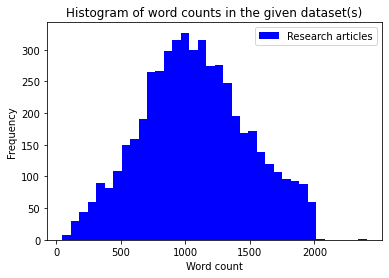

In [70]:
plot_hist([research_articles_raw], ["Research articles"], [], "blue")

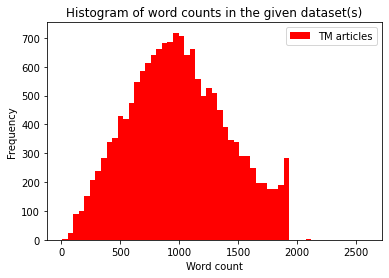

In [71]:
plot_hist([tm_articles_raw], ["TM articles"], [], "red")

There are a few records that contain unusually few or many words in them, but this is not a concern for us since the number of words in a document doesn't affect the topic distribution.

Since we are going to be predicting topics lets see the topic distributions in the datasets.

Here we will define a function that we will use from now on for demonstrating our models' predictions.

In [72]:
def plot_topic_dist(topic_dists, names, doc_name, topic_names=[], correct=None):
    """
    Plots a barchart for the topic distributions for 1 or more topic models
    topic_dists - a list of lists of topic distributons each for 1 model
    names - model names
    Example:
    topic_dists = [[0.5, 0.3, 0.1, 0.1], [0.48, 0.31, 0.11, 0.1]]
    names = ['LDA', 'PMA']
    plot_topic_dist(topic_dists, names)
    """
    names_count = len(names)
    fig, ax = plt.subplots()
    ax.set_ylabel('Score')
    ax.set_xlabel('Topic')
    
    prefix = "Topic distribution for "
    suffix = " on doc " + str(doc_name)
    if names_count == 1:
        ax.set_title(prefix + "{} model".format(*names) + suffix)
    elif names_count == 2:
        ax.set_title(prefix + "{} and {} models".format(*names) + suffix)
    else:
        ax.set_title(prefix + "".join([name + ", " for name in names]) +
                    names[-1] + " models".format(*names) + suffix) # Took way too much time but its pretty :)
        
    x = np.arange(len(topic_dists[0]))
    plt.xticks(rotation=45)
    ax.set_xticks(x)
    if len(topic_names):
        ax.set_xticklabels(topic_names)
    else:
        ax.set_xticklabels([" #{}".format(i) for i in x])
    
    bar_width = 0.35
    topic_count = len(topic_dists[0])
    for i, dist in enumerate(topic_dists):
        labels = np.arange(len(dist))
        ax.bar(x - bar_width/2 + i*  bar_width/2, dist, bar_width, label=names[i])
        
    if correct != None:
        correct_bars = np.zeros(topic_count)
        correct_bars[correct]=1
        ax.bar(x - bar_width/2 + i*  bar_width/2, correct_bars, bar_width/2, label="Correct (not dist)", color="lightgreen")
    
    ax.legend()
    fig.tight_layout()
    plt.show()

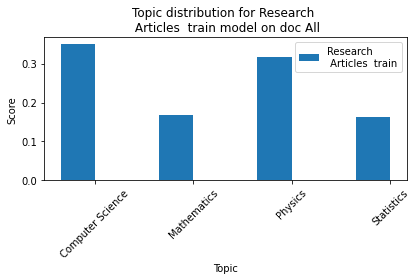

In [73]:
topic_dist_df_test = np.array([np.sum(df_test[topic].tolist()) for topic in test_topics])/df_test.shape[0]
plot_topic_dist([topic_dist_df_test], ["Research \n Articles  train"],"All", topic_names = test_topics)

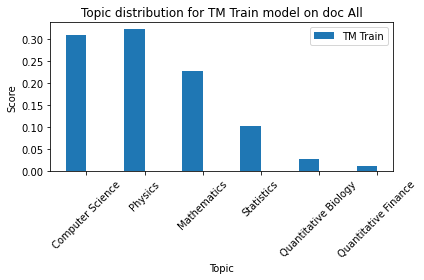

In [74]:
topic_dist_tm_train = np.array(tm_train["Topic ID"].value_counts().sort_index().tolist())/tm_train.shape[0]
plot_topic_dist([topic_dist_tm_train], ["TM Train"],"All", topic_names = tm_train_topics)

# <div class="alert alert-block alert-info">3. LDA </div> <a class="anchor" id="LDA"></a>

LDA is a commonly used algorithm in Topic modeling and it has been added to famous python libraries. Documentation about the LDA model provided in __gensim__ can be found <a href="https://radimrehurek.com/gensim/models/ldamodel.html">here</a> and sklearn <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html">here</a>.
<br>
<br>
However, with regards to the purpose of this notebook, using them feels like cheating and in order to fully understand how it works we are going to implement it from scratch.

## 3.1 Assumptions <a class="anchor" id="Assumptions_LDA"></a>

When writing any sort of ML, assumptions are __exremely__ important. That's how we know what the model could miss in the data.

Latent Dirichlet Allocation models assume that:

1. Each document is just a collection of words or a “bag of words”. Thus, the order of the words and the grammatical role of the words (subject, object, verbs, etc.) are not considered in the model.
<br>
2. Words like am/is/are/of/a/the/but (called __stopwords__) don’t carry any information about the “topics” and therefore can be eliminated from the documents as a preprocessing step. Moreover, words that appear in 80%-90% can be completely eliminated without a loss of information.
<br>
3. The number of topics is known beforehand.
<br>
4. All topic assignments except for the current word in question are correct, and then updating the assignment of the current word using our model of how documents are generated.

# 3.2 Preparing our data <a class="anchor" id="Preparing_our_data_LDA"></a>

Before we create our LDA model, there are still things that we can do to make it more efficient. In consensus with the assumptions listed above, we can get rid of the stopwords in the documents as they don't carry meaning that is exclusive to a particular topic. This can be done either by iterating through the entire dataset and filtering those words out in each document or __not letting our model use them__ by excluding them in the model's vocabulary. Both options have pros and cons. For performance reasons as well as reusing the original dataset later, we will go the second way.

Conveniently, we can accomplish both tasks in 1 shot by using sklearn's 
```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)
```
For this notebook, we will use the following arguments:
* <code>lowercase</code> - Convert all characters to lowercase before tokenizing
* <code>stop_words</code> - Use a built-in stop word list or pass a custom one(recommended).
* <code>max_df</code> - Threshold for highest acceptable frequency of a term in the entire corpus.
* <code>min_df</code> - Threshold for lowest acceptable frequency of a term in the entire corpus.
* <code>max_features</code> - Maximal vocabulary length of words ordered by frequency accross the corpus.


With the method
```python
fit_transform(raw_documents, y=None)
```
we learn the vocabulary and can access it in the attribute of the same name.
<br>
<br>
Full documentation of the class can be found <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html">here</a>.
<br>
<br>

First we store a copy of the stopwords in the ```stopwords_voc``` variable:

In [75]:
stopwords_voc = list(stopwords.words("english"))

In [76]:
stopwords_voc

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

A good practice for topic modeling is to have a domain specific set of stop word list along with the standard ones. Otherwise, these words like "introduction","review", "considering" etc. will come up in the term frequency matrix, if you have tried out analysing it. It can mislead the model by giving more weights to these domain specific keywords.

<br>
<br>
Because of that we are going to add a few more words in that list.

In [77]:
stopwords_voc += ['inside','also', 'considering', 'one', 'two', 'three', 'model', 'data', 'based', 'system']
stopwords_voc += ['method','show', 'using', 'results', 'paper', 'time'] 

Then we create an instance of ```CountVectorizer``` that will exclude the stopwords above from each abstract to create a vocabulary.

In [78]:
count_vectorizer = CountVectorizer(max_df=0.9, min_df=0.001, max_features=10000, stop_words=stopwords_voc)

Now lets tokenize the text and create a bag of words document representation of our corpus to use in our model.

In [79]:
training_articles = tm_articles

tf = count_vectorizer.fit_transform(training_articles)
vocabulary = count_vectorizer.vocabulary_

In [80]:
{k: v for k, v in sorted(vocabulary.items(), key=lambda item: item[1])}

{'1d': 0,
 '2d': 1,
 '3d': 2,
 '5g': 3,
 'aa': 4,
 'ab': 5,
 'abelian': 6,
 'ability': 7,
 'able': 8,
 'abnormal': 9,
 'abrupt': 10,
 'absence': 11,
 'absent': 12,
 'absolute': 13,
 'absolutely': 14,
 'absorb': 15,
 'absorber': 16,
 'absorption': 17,
 'abstract': 18,
 'abstraction': 19,
 'abundance': 20,
 'abundant': 21,
 'ac': 22,
 'academia': 23,
 'academic': 24,
 'accelerate': 25,
 'accelerated': 26,
 'acceleration': 27,
 'accelerator': 28,
 'accelerometer': 29,
 'accept': 30,
 'acceptable': 31,
 'acceptance': 32,
 'access': 33,
 'accessibility': 34,
 'accessible': 35,
 'accident': 36,
 'accommodate': 37,
 'accompany': 38,
 'accomplish': 39,
 'accord': 40,
 'accordance': 41,
 'according': 42,
 'accordingly': 43,
 'account': 44,
 'accounting': 45,
 'accrete': 46,
 'accretion': 47,
 'accumulate': 48,
 'accumulation': 49,
 'accuracy': 50,
 'accurate': 51,
 'accurately': 52,
 'achievable': 53,
 'achieve': 54,
 'achievement': 55,
 'achieves': 56,
 'acid': 57,
 'acoustic': 58,
 'acquire':

Lets see how our dataset has changed in the eyes of our model

In [81]:
pd.set_option('display.max_colwidth', None)
test_doc = training_articles[1]
test_doc_nostops = " ".join([w for w in test_doc.lower().split() if w in vocabulary.keys()])
pd.DataFrame([[test_doc,test_doc_nostops]], columns=["Before", "After"])

,Before,After
0,Rotation invariance and translation invariance have great value in image recognition task In this paper we bring a new architecture in convolutional neural network CNN name cyclic convolutional layer to achieve rotation invariance in D symbol recognition We can also get the position and orientation of the D symbol by the network to achieve detection purpose for multiple nonoverlap target Last but not least this architecture can achieve oneshot learning in some case use those invariance,rotation invariance translation invariance great value image recognition task bring new architecture convolutional neural network cnn name cyclic convolutional layer achieve rotation invariance symbol recognition get position orientation symbol network achieve detection purpose multiple target last least architecture achieve oneshot learning case use invariance


To reset the pandas display option, execute the next cell.

In [82]:
pd.set_option('display.max_colwidth', 50)

Now lets get rid of the words and transform them into ids that are easier to work with.

In [83]:
docs = []
for doc_word in tf.toarray():
    present_words = np.where(doc_word != 0)[0].tolist()
    present_words_with_count = []

    for word in present_words:
        for count in range(doc_word[word]):
            present_words_with_count.append(word)
    docs.append(present_words_with_count)


## 3.3 Implementation <a class="anchor" id="Implementation_LDA"></a>

There are 2 parts in LDA:
1. The words that belong to a document, that we already know.
2. The words that belong to a topic or the probability of words belonging into a topic, that we need to calculate.

The algorithm to completing the second part, in pure english goes like:

1. Go through each document and randomly assign each word in the document to one of K topics (T is chosen beforehand).
2. For each document d, go through each word w and compute :
 * p(topic t | document d): the proportion of words in document d that are assigned to topic $ t $. Tries to capture how many words belong to the topic t for a given document d. Excluding the current word.
<br>
If a lot of words from d belongs to t, it is more probable that word w belongs to t.
<br>
( number of words in d with t + alpha/ #words in d with any topic+ k*alpha)
 * p(word w| topic t): the proportion of assignments to topic t over all documents that come from this word w. Tries to capture how many documents are in topic t because of word w.
LDA represents documents as a mixture of topics. Similarly, a topic is a mixture of words. If a word has high probability of being in a topic, all the documents having w will be more strongly associated with t as well. Similarly, if w is not very probable to be in t, the documents which contain the w will be having very low probability of being in t, because rest of the words in d will belong to some other topic and hence d will have a higher probability for those topic. So even if w gets added to t, it won’t be bringing many such documents to t.
Update the probability for the word w belonging to topic t with the probability of topic t belonging to document d times the probability of word w belonging to topic t

Several parameters will be used in the making, which I am going to write here and explain. In LDA the two parameters we are most interested in are 

* $ \varphi $ - the word distribution for topic
* $ \theta $ - the distribution of topics over the documents

Specifically $\theta_{i}$ is the topic distribution for document __$i$__, a probability vector. Since each topic is characterized by a distribution over words, we also introduce __$ \varphi_{k} $__ as the word distribution for topic __$k$__.
Each of our topic distributions of a document is basically a probability vector, so we can view it as a multinomial distribution over the topics. Hence $\theta$ is a distribution over multinomial distributions, which is exactly what a Dirichlet distribution is. The graph we used earlier to represent the mixture of topics in documents re-ensembles the probability density function of a dirichlet distribution with 3 categorical events. So we will model the distribution of topics over the documents $\theta$ and the word distribution for topics $\varphi$ by dirichlet distributions of order TT, respectively VV.

Other than that we have $\alpha$, the parameter of the Dirichlet prior on the per-document topic distributions and $\beta$, the parameter of the Dirichlet prior on the per-topic word distribution. Usually both parameters are sparse, meaning they are smaller than 1.
<br>
<br>
Symmetrical priors are often the default setting for LDA tools such as Mallet and Gensim and assume a priori that each of the T topics has an equal probability of being assigned to a document while each word has an equal chance of being assigned to a topic. For the symmetrical prior $ \alpha $, the hyperparameter is a vector with the value $1/T$, where T is the number of topics. The symmetrical prior $ \beta $ has a scalar parameter with the value $1/V$ , where $V$ is the size of the vocabulary (full-text data). 

<br>
For the asymmetrical priors, we should utilize an iterative learning process to approximate the hyperparameters from the data,
estimation is required as no exact closed form solution exists. 
<br>
<br>
In both scenarios, estimating hyperparameters can be used to increase model quality, and their values can reveal specific properties of the corpus: $ \alpha $ for the distinctiveness in underlying semantic structures and $ \beta $ for the group size of commonly co-occurring words. 
<br>
Several methods for hyperparameter estimation exist, such as gradient ascent, fixed point iteration, and <a href="https://brilliant.org/wiki/newton-raphson-method/#:~:text=The%20Newton%2DRaphson%20method%20(also,straight%20line%20tangent%20to%20it.">Newton-Raphson method</a>.
<br>
<br>
For this notebook we will stick with the default choice and use symmetric standart priors.

Our dataset and vocabulary are good to go and we are ready for the next step, which is to define the variables we will be working with.


```topic_per_doc_word``` - a 2 dimensional list in which we will store the topic for each word in each document from the dataset

Example: ```topic_per_doc_word[docNumber][wordNumer]```

In [84]:
n_samples = len(vocabulary)

D = len(docs)        # number of documents
V = len(vocabulary)  # size of the vocabulary 
T = 6              # number of topics

alpha = 1 / T         # the parameter of the Dirichlet prior on the per-document topic distributions
beta = 1 / V        # the parameter of the Dirichlet prior on the per-topic word distribution


topic_per_doc_word = [[0 for _ in range(len(doc))] for doc in docs]
theta = np.zeros((D, T))
phi = np.zeros((T, V))

n_d = np.zeros((D))
n_z = np.zeros((T))

# 3.4 Gibbs Sampling <a class="anchor" id="Gibbs_Sampling"></a>

Gibbs sampling is an algorithm for successively sampling conditional distributions of variables, whose distribution over states converges to the true distribution in the long run. 

In its moset standard implementation, it cycles through all variables and model parameters and randomly samples each one from a conditional distribution where we’re conditioning on the previously sampled values of all the other model parameters and assignment variables, and we’re also conditioning on our observations. Because of the special structure of our LDA model, we can actually analytically marginalize over all of the uncertainty in our model parameters and just sample the word assignment variable ```topic_per_word```. This is called “collapsed gibbs sampling”.

We do the sampling of a new ```topic_per_word[i][j]``` for $j$th word in $i$th document by the following formula:

$$ P(z_{ij} \mid word_{ij}, k \neq i, l \neq j,w) =  \frac{\theta_{ik}\alpha}{N_{i} + \alpha T} \frac{\varphi_{kw} + \beta}{ \sum_{w \in V}{\varphi_{kw}+\beta V}} $$

First, we initialize our parameters.

In [85]:
for d, doc in enumerate(docs):
    for n, w in enumerate(doc): # n: id of word inside document, w: id of the word globally
        # select a random topic for words
        topic_per_doc_word[d][n] = n % T
        z = topic_per_doc_word[d][n]
        
        # keep track of our counts
        theta[d][z] += 1
        phi[z, w] += 1
        n_z[z] += 1
        n_d[d] += 1

Then we start training the model.

In [86]:
iterations = 20

print('Starting training LDA model')
for iteration in tqdm(np.linspace(0, 100, iterations)):
    for d, doc in enumerate(docs):
        for n, w in enumerate(doc):
            # get the topic for word n in document m
            z = topic_per_doc_word[d][n]

            # decrement counts for word w with associated topic z
            theta[d][z] -= 1
            phi[z, w] -= 1
            n_z[z] -= 1

            # sample new topic from a multinomial according to our formula above
            p_d_t = (theta[d] + alpha) / (n_d[d] - 1 + T * alpha)
            p_t_w = (phi[:, w] + beta) / (n_z + V * beta)
            p_z = p_d_t * p_t_w
            p_z /= np.sum(p_z)
            new_z = np.random.multinomial(1, p_z).argmax()

            # set z as the new topic and increment counts
            topic_per_doc_word[d][n] = new_z
            theta[d][new_z] += 1
            phi[new_z, w] += 1
            n_z[new_z] += 1

Starting training LDA model


  0%|          | 0/20 [00:00<?, ?it/s]

Before we continue we can pack everything in a class to use later.

In [87]:
class LDA:
    def __init__(self, corpus, stopwords_voc, topic_count):
        
        self.count_vectorizer = CountVectorizer(max_df=0.85, max_features=10000, stop_words=stopwords_voc)
        self.tf = self.count_vectorizer.fit_transform(corpus)
        
        self.docs = []
        for doc_word in self.tf.toarray():
            present_words = np.where(doc_word != 0)[0].tolist()
            present_words_with_count = []

            for word in present_words:
                for count in range(doc_word[word]):
                    present_words_with_count.append(word)
            self.docs.append(present_words_with_count)
            
        
        self.n_samples = 10000
        self.corpus = corpus
        
        self.vocabulary = self.count_vectorizer.vocabulary_
         
        self.D = len(self.docs)        # number of documents
        self.V = len(self.vocabulary)  # size of the vocabulary 
        self.T = topic_count              # number of topics

        self.alpha = 0.1 / self.T         # the parameter of the Dirichlet prior on the per-document topic distributions
        self.beta = 0.1 / self.V        # the parameter of the Dirichlet prior on the per-topic word distribution


        self.topic_per_doc_word = [[0 for _ in range(len(doc))] for doc in self.docs]
        self.theta = np.zeros((self.D, self.T))
        self.phi = np.zeros((self.T, self.V))

        self.n_d = np.zeros((self.D))
        self.n_z = np.zeros((self.T))
        
        
    
        for d, doc in enumerate(self.docs):
            for n, w in enumerate(doc): # n: id of word inside document, w: id of the word globally
                # select a random topic for words
                self.topic_per_doc_word[d][n] = n % self.T
                z = self.topic_per_doc_word[d][n]

                # keep track of our counts
                self.theta[d][z] += 1
                self.phi[z, w] += 1
                self.n_z[z] += 1
                self.n_d[d] += 1
        
    def train(self, iterations):
        print('Starting training LDA model')
        for iteration in tqdm(np.linspace(0, 100, iterations)):
            for d, doc in enumerate(self.docs):
                for n, w in enumerate(doc):
                    # get the topic for word n in document m
                    z = self.topic_per_doc_word[d][n]

                    # decrement counts for word w with associated topic z
                    self.theta[d][z] -= 1
                    self.phi[z, w] -= 1
                    self.n_z[z] -= 1

                    # sample new topic from a multinomial according to our formula above
                    p_d_t = (self.theta[d] + self.alpha) / (self.n_d[d] - 1 + self.T * self.alpha)
                    p_t_w = (self.phi[:, w] + self.beta) / (self.n_z + self.V * self.beta)
                    p_z = p_d_t * p_t_w
                    p_z /= np.sum(p_z)
                    new_z = np.random.multinomial(1, p_z).argmax()

                    # set z as the new topic and increment counts
                    self.topic_per_doc_word[d][n] = new_z
                    self.theta[d][new_z] += 1
                    self.phi[new_z, w] += 1
                    self.n_z[new_z] += 1
                    
    def get_doc_dist(self, doc_index):
        return self.theta[doc_index]/ sum(self.theta[doc_index])
    
    def get_top_words(self, n_top_words):
        inv_vocabulary = {v: k for k, v in self.vocabulary.items()}
        output = dict()
        for topic_idx, topic in enumerate(self.phi):
            output[topic_idx] = [inv_vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        return output
    
    def infer(self, doc):
        #TODO
        return

In [88]:
doc_index = 14

Now we will create a function that we will use later on to make predictions.

In [89]:
def get_doc_dist(doc_index):
    return theta[doc_index]/ sum(theta[doc_index])

Topic #0: use network propose approach image learn performance learning task base
Topic #1: graph group problem set give result algorithm structure network number
Topic #2: function equation result space problem solution prove give matrix use
Topic #3: use problem algorithm propose approach result study base provide distribution
Topic #4: find mass use star galaxy high large observation result spectrum
Topic #5: state phase field energy quantum magnetic interaction transition study temperature


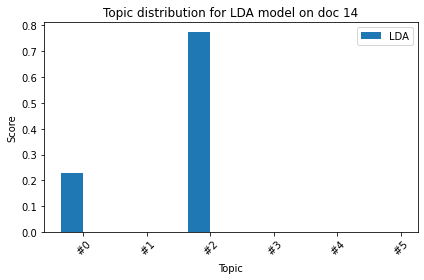

In [90]:
inv_vocabulary = {v: k for k, v in vocabulary.items()}
n_top_words = 10
for topic_idx, topic in enumerate(phi):
    message = "Topic #%d: " % topic_idx
    message += " ".join([inv_vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

    
lda_dist=get_doc_dist(doc_index)
plot_topic_dist([lda_dist],["LDA"],doc_index)

# <div class="alert alert-block alert-info">4. Pachinko Allocation Model </div> <a class="anchor" id="PAM"></a>

As we said earlier, the Pachimnko Allocation Model uses Directed Acyclic Graph. 
<br>
In it, the nodes represent the topics that are to be connected together. Therefore, each node represents a topic. Attributes of the topic represents the words that are related to the particular topic.
<br>
<br>

<center>
    <figure>
        <img src = https://slideplayer.com/slide/15052932/91/images/23/Pachinko+Allocation+Model.jpg alt="Pachinko DAG"></img>
    <figcaption><strong>Pachinko DAG</strong></figcaption>
    </figure>
</center>
<br>
<br>

In this model, each leaf node(node that doesn't have any connections) corresponds to the words present in the vocabulary and each non-leaf node represents the inner subtopics. In the picture above the closer a non-leaf node is to the root, the more _"general"_ topic representation it gives(called __super topics__). 
<br>
<br>
In an arbitrary DAG, a LDA model would not have the links between those non leaf interior nodes. Thats how the PAM model uses the links between them to have a tight complete coherence throughout the corpus.
<br>
<br>

# 4.1 Assumptions <a class="anchor" id="Assumptions_PAM"></a>

Because it is based on LDA, some of Pachinko's ancestor's assumptions are inherited in this model.

Pachinko Allocation models assume that:

1. Each document is just a collection of words or a “bag of words”. Thus, the order of the words and the grammatical role of the words (subject, object, verbs, etc.) are not considered in the model.
<br>
2. Words like am/is/are/of/a/the/but/ (called __stopwords__) don’t carry any information about the “topics” and therefore can be eliminated from the documents as a preprocessing step. Moreover, words that appear in 80%-90% can be completely eliminated without a loss of information.
<br>
3. The number of topics and number of subtopics is known beforehand.

# 4.2 Preparing our data <a class="anchor" id="Preparing_our_data_PAM"></a>

Our task of data preparation for this model is similar to the one we did for the LDA model, with the twist that we need the true list of documents with stop words removed rather than vocabulary.

The model takes each article as a list of words instead of a whole string so we need to make a conversion.

In [91]:
training_articles_pam = tm_articles

In [92]:
def split_words(docs, stopwords_voc):
    """
    Converts each document from `docs` to an array of LOWERCASE words,
    by also removing stopwords and punctuation. Returns list of lists.
    """
    no_punctuation=list()
    for i, article in enumerate(training_articles_pam):
        no_punctuation.append(re.sub(r'[^\w\s]','',article.lower()))
        
    output = list()
    for article in no_punctuation:
        new_doc = [word for word in article.split() if (word not in stopwords_voc)]
        output.append(new_doc)
    return output

In [93]:
cleaned_articles = split_words(training_articles_pam, stopwords_voc)

While we are on it let me take the opportunity to show how the effect of removing stopwords with a histogram:

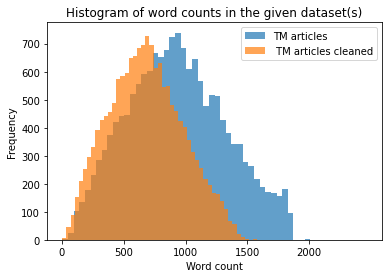

In [94]:
plot_hist([tm_articles, [" ".join(doc) for doc in cleaned_articles]], ["TM articles"," TM articles cleaned"], [])

# 4.3 Example <a class="anchor" id="Example_PAM"></a>

Pachinko Allocation model is a model that isn't currently included in the famous libraries for AI in python. A library called Tomotopy has an implementation of the model among other topic models. (Documentation <a href="https://bab2min.github.io/tomotopy/v0.12.1/en/#tomotopy.PAModel">here</a>)

The part of the documentation that will be relevant for us is:


```python
class PAModel(tw=TermWeight.ONE, min_cf=0, min_df=0, rm_top=0, 
              k1=1, k2=1, alpha=0.1, subalpha=0.1, eta=0.01, 
              seed=None, corpus=None, transform=None)
```
where

* ```k1``` - the number of super topics between 1 ~ 32767
* ```k2``` - the number of sub topics between 1 ~ 32767
* ```min_cf``` - minimum collection frequency of words
* ```rm_top``` - the number of top words to be removed for when you want to remove too common words from model
* ```corpus``` - a list of documents to be added into the model

the class methods that we are going to use are explained here:

```python
def add_doc(self, words) # Add a new document into the model instance and return an index of the inserted document.

def get_topic_words(self, sub_topic_id, top_n=10) # Return the top_n words and its probability in the sub topic sub_topic_id.

def get_sub_topics(self, super_topic_id, top_n=10) # Return the top_n sub topics and its probability in a super topic super_topic_id.

def infer(self, doc, iter=100, tolerance=-1, workers=0, parallel=0, together=False) # Return the inferred topic distribution and sub-topic distribution from unseen docs.
```

In [95]:
mdl = tp.PAModel(k1=6, k2=30, min_cf=100)
for doc in cleaned_articles:
    mdl.add_doc(doc)

print('Starting training PAM model')
iterations = 50
for i in tqdm(np.linspace(0, 100, iterations)):
    mdl.train(1)

Starting training PAM model


  0%|          | 0/50 [00:00<?, ?it/s]

In [96]:
pam_supertopic_top_words = dict()
for k in range(mdl.k1):
    subtopics = mdl.get_sub_topics(k)
    print('\n\nSubtopics of topic #%s: ' % k + " ".join([str(i[0]) for i in subtopics]))
    pam_supertopic_top_words[k] = list()
    for subtopic, probability in subtopics:
        subtopic_top_words = [str(i[0]) for i in mdl.get_topic_words(subtopic, top_n=10)]
        print('    Top 10 words of subtopic topic {}: {}'.format(subtopic, " ".join(subtopic_top_words)))
        pam_supertopic_top_words[k] += subtopic_top_words



Subtopics of topic #0: 16 28 4 26 29 12 8 3 22 2
    Top 10 words of subtopic topic 16: group space prove give algebra result finite manifold study theory
    Top 10 words of subtopic topic 28: magnetic field phase spin state temperature transition order effect interaction
    Top 10 words of subtopic topic 4: research study provide analysis work human new discuss community review
    Top 10 words of subtopic topic 26: use performance design application software memory present provide implementation cost
    Top 10 words of subtopic topic 29: algorithm problem propose optimization optimal approach solve use performance function
    Top 10 words of subtopic topic 12: surface material structure layer pressure property film mode transport interface
    Top 10 words of subtopic topic 8: equation solution condition problem operator function boundary result nonlinear differential
    Top 10 words of subtopic topic 3: graph problem algorithm bound number set give tree result vertex
    Top 

In [97]:
mdl.get_topic_words(subtopic, top_n=10)

[('use', 0.016917625442147255),
 ('performance', 0.01624763011932373),
 ('design', 0.01459656935185194),
 ('application', 0.013783003203570843),
 ('software', 0.010050171054899693),
 ('memory', 0.009140891954302788),
 ('present', 0.009069106541574001),
 ('provide', 0.008255540393292904),
 ('implementation', 0.008207683451473713),
 ('cost', 0.008159827440977097)]

In [98]:
doc = mdl.make_doc(cleaned_articles[doc_index])
pam_dist = mdl.infer(doc)[0][0]

# <div class="alert alert-block alert-info">5. Model Comparisson </div> <a class="anchor" id="Model_Comparisson"></a>

To start off clean in this section we are going to create a new instance of each model.

We have got 2 datasets with overlapping topics. The most logical thing to do for a proper training is to use the bigger one.

In [99]:
len(tm_articles)

15928

In [100]:
len(research_articles)

5042

We will train both models on 200 iterations and the Pachinko model on 18 000 because of its complex structure.

## 5.1 Performance <a class="anchor" id="Performance"></a>

We first initialize and train an LDA model. To make things comparable we will use the dataset that we used for Pachinko.

In [101]:
%time tm_lda = LDA(tm_articles,stopwords_voc,6)

Wall time: 5.81 s


In [102]:
%time tm_lda.train(200)

Starting training LDA model


  0%|          | 0/200 [00:00<?, ?it/s]

Wall time: 2h 34min 51s


Now we will initialize and train a new pachinko model.

In [103]:
%%time 
tm_pam = tp.PAModel(k1=6, k2=10, min_cf=100)
for doc in cleaned_articles:
    tm_pam.add_doc(doc)

Wall time: 512 ms


In [104]:
%%time
for i in tqdm(np.linspace(0, 100, 18000)):
    tm_pam.train(1)

  0%|          | 0/18000 [00:00<?, ?it/s]

Wall time: 39min 41s


The difference in training time is startling and could be caused mainly by required optimization and data processing. Using numpy arrays instead of pythonic ones can shorten the time for training the LDA model.

## 5.1 Accuracy <a class="anchor" id="Accuracy"></a>

Now that we have two(eventually working) models, lets compare how they distribute topics for the first 100 documents from the dataset and compare it to the actual distribution. Because both models only take a fixed number of topics and at the start words are distributed randomly, the indexes of topics are also random.
<br>
<br>
I will reorder both model's distributions in advance based on the real distribution down below.

We will get the topic distribution for the first 100 documents for the 2 models from the dataset and normalize.

In [107]:
lda_100_docs_dist = tm_train_topics_count*[0]
for i in range(100):
    new_doc_dist = tm_lda.get_doc_dist(i)
    lda_100_docs_dist = list(map(add, lda_100_docs_dist, new_doc_dist))

In [108]:
pam_100_docs_dist = tm_train_topics_count*[0]
for i in tqdm(range(100)):
    doc = mdl.make_doc(cleaned_articles[i])
    new_doc_dist = mdl.infer(doc)[0][0]
    pam_100_docs_dist = list(map(add, pam_100_docs_dist, new_doc_dist))

  0%|          | 0/100 [00:00<?, ?it/s]

In [109]:
lda_100_docs_dist_normalized = np.array(lda_100_docs_dist)/100

In [110]:
pam_100_docs_dist_normalized = np.array(pam_100_docs_dist)/100

In [111]:
lda_topic_id_converter = [0,5,2,3,4,1]

In [112]:
pam_topic_id_converter = [2,0,4,5,1,3]

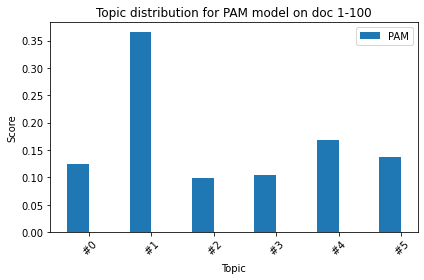

In [113]:
plot_topic_dist([[pam_100_docs_dist_normalized[i] for i in pam_topic_id_converter]], ["PAM"],"1-100") #150 its

Just to get a raw idea of what the perfect distribution would look like we can get the frequency of each topic from the dataset and normalize by the dataset length.

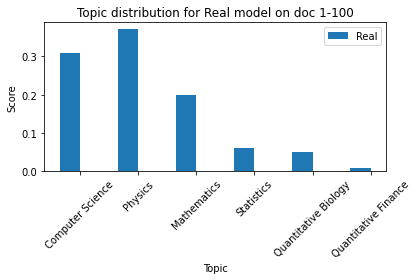

In [114]:
real_dist = np.array(tm_train["Topic ID"][:100].value_counts().sort_index().tolist())/100
plot_topic_dist([real_dist], ["Real"],"1-100", topic_names = tm_train_topics)

Since both models are trained on the same dataset and with equal number of topics (super topics for PAM), we can suppose that the top words for each topic would be similar.


<div class="alert alert-block alert-danger"> This approach didn't work but I will leave it here for reference.
</div>

In [115]:
pam_supertopic_top_words = dict()
for k in range(tm_pam.k1):
    subtopics = tm_pam.get_sub_topics(k)
    pam_supertopic_top_words[k] = list()
    for subtopic, probability in subtopics:
        subtopic_top_words = [str(i[0]) for i in tm_pam.get_topic_words(subtopic, top_n=10)]
        pam_supertopic_top_words[k] += subtopic_top_words

In [116]:
def show_match_count():
    for t in range(tm_pam.k1):
        inv_vocabulary = {v: k for k, v in tm_lda.vocabulary.items()}
        n_top_words = 1000
        
        for topic_idx, topic in enumerate(tm_lda.phi):
            lda_top_words = [inv_vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
            
            matching_words = set(pam_supertopic_top_words[t]).intersection(set(lda_top_words))
            print("LDA topic {} to PAM {} - {}".format(topic_idx, t, len(matching_words)))
        print("====")
show_match_count()

LDA topic 0 to PAM 0 - 55
LDA topic 1 to PAM 0 - 45
LDA topic 2 to PAM 0 - 34
LDA topic 3 to PAM 0 - 44
LDA topic 4 to PAM 0 - 45
LDA topic 5 to PAM 0 - 38
====
LDA topic 0 to PAM 1 - 55
LDA topic 1 to PAM 1 - 45
LDA topic 2 to PAM 1 - 34
LDA topic 3 to PAM 1 - 44
LDA topic 4 to PAM 1 - 45
LDA topic 5 to PAM 1 - 38
====
LDA topic 0 to PAM 2 - 55
LDA topic 1 to PAM 2 - 45
LDA topic 2 to PAM 2 - 34
LDA topic 3 to PAM 2 - 44
LDA topic 4 to PAM 2 - 45
LDA topic 5 to PAM 2 - 38
====
LDA topic 0 to PAM 3 - 55
LDA topic 1 to PAM 3 - 45
LDA topic 2 to PAM 3 - 34
LDA topic 3 to PAM 3 - 44
LDA topic 4 to PAM 3 - 45
LDA topic 5 to PAM 3 - 38
====
LDA topic 0 to PAM 4 - 55
LDA topic 1 to PAM 4 - 45
LDA topic 2 to PAM 4 - 34
LDA topic 3 to PAM 4 - 44
LDA topic 4 to PAM 4 - 45
LDA topic 5 to PAM 4 - 38
====
LDA topic 0 to PAM 5 - 55
LDA topic 1 to PAM 5 - 45
LDA topic 2 to PAM 5 - 34
LDA topic 3 to PAM 5 - 44
LDA topic 4 to PAM 5 - 45
LDA topic 5 to PAM 5 - 38
====


Lets write a function that will give us a score of correctly guessed documents.

In [117]:
def get_model_score(dataframe, n, order_converter, model, model_type="LDA"):
    """
    Returns percentage of correctly guessed topic distributions divided by the `n` number of `dataframe` docs examined
    for a `model_type` - ["LDA", "PAM"]
    """
    score = 0
    results = list()
    corrects = list()
    for i in range(n):
        doc_index=i
        sample = dataframe.iloc[doc_index]
        
        if model_type == "LDA":
            model_dist = model.get_doc_dist(doc_index)
        else:
            doc = tm_pam.make_doc(split_words(dataframe["ABSTRACT"], [])[i])
            model_dist = model.infer(doc)[0][0]
    
        converted_dist = [model_dist[i] for i in order_converter]
        correct = dataframe.iloc[doc_index]["Topic ID"]
        
        if converted_dist[correct] == max(converted_dist):
            score+=1
    
        results.append(converted_dist)
        corrects.append(correct)
    return score/n, results, corrects
    

In [118]:
score_lda, doc_dists_lda, corrects = get_model_score(tm_train, 100, lda_topic_id_converter, tm_lda)
score_lda

0.38

In [119]:
score_pam, doc_dists_pam, corrects = get_model_score(tm_train, 100, pam_topic_id_converter, tm_pam, "PAM")
score_pam

0.22

Seems like ordering the topics by looking just at the distribution won't give us the best results.

We will take a cheeky way around and try to bruteforce the correct ordering. Since we have a small number of topics we can use their permutations to find the optimal one.

In [120]:
permutations = np.array([[0,1,2,3,4,5],[1,0,2,3,4,5],[2,0,1,3,4,5],[0,2,1,3,4,5],[1,2,0,3,4,5],[2,1,0,3,4,5],[2,1,3,0,4,5],[1,2,3,0,4,5],[3,2,1,0,4,5],[2,3,1,0,4,5],[1,3,2,0,4,5],[3,1,2,0,4,5],[3,0,2,1,4,5],[0,3,2,1,4,5],[2,3,0,1,4,5],[3,2,0,1,4,5],[0,2,3,1,4,5],[2,0,3,1,4,5],[1,0,3,2,4,5],[0,1,3,2,4,5],[3,1,0,2,4,5],[1,3,0,2,4,5],[0,3,1,2,4,5],[3,0,1,2,4,5],[4,0,1,2,3,5],[0,4,1,2,3,5],[1,4,0,2,3,5],[4,1,0,2,3,5],[0,1,4,2,3,5],[1,0,4,2,3,5],[1,0,2,4,3,5],[0,1,2,4,3,5],[2,1,0,4,3,5],[1,2,0,4,3,5],[0,2,1,4,3,5],[2,0,1,4,3,5],[2,4,1,0,3,5],[4,2,1,0,3,5],[1,2,4,0,3,5],[2,1,4,0,3,5],[4,1,2,0,3,5],[1,4,2,0,3,5],[0,4,2,1,3,5],[4,0,2,1,3,5],[2,0,4,1,3,5],[0,2,4,1,3,5],[4,2,0,1,3,5],[2,4,0,1,3,5],[3,4,0,1,2,5],[4,3,0,1,2,5],[0,3,4,1,2,5],[3,0,4,1,2,5],[4,0,3,1,2,5],[0,4,3,1,2,5],[0,4,1,3,2,5],[4,0,1,3,2,5],[1,0,4,3,2,5],[0,1,4,3,2,5],[4,1,0,3,2,5],[1,4,0,3,2,5],[1,3,0,4,2,5],[3,1,0,4,2,5],[0,1,3,4,2,5],[1,0,3,4,2,5],[3,0,1,4,2,5],[0,3,1,4,2,5],[4,3,1,0,2,5],[3,4,1,0,2,5],[1,4,3,0,2,5],[4,1,3,0,2,5],[3,1,4,0,2,5],[1,3,4,0,2,5],[2,3,4,0,1,5],[3,2,4,0,1,5],[4,2,3,0,1,5],[2,4,3,0,1,5],[3,4,2,0,1,5],[4,3,2,0,1,5],[4,3,0,2,1,5],[3,4,0,2,1,5],[0,4,3,2,1,5],[4,0,3,2,1,5],[3,0,4,2,1,5],[0,3,4,2,1,5],[0,2,4,3,1,5],[2,0,4,3,1,5],[4,0,2,3,1,5],[0,4,2,3,1,5],[2,4,0,3,1,5],[4,2,0,3,1,5],[3,2,0,4,1,5],[2,3,0,4,1,5],[0,3,2,4,1,5],[3,0,2,4,1,5],[2,0,3,4,1,5],[0,2,3,4,1,5],[1,2,3,4,0,5],[2,1,3,4,0,5],[3,1,2,4,0,5],[1,3,2,4,0,5],[2,3,1,4,0,5],[3,2,1,4,0,5],[3,2,4,1,0,5],[2,3,4,1,0,5],[4,3,2,1,0,5],[3,4,2,1,0,5],[2,4,3,1,0,5],[4,2,3,1,0,5],[4,1,3,2,0,5],[1,4,3,2,0,5],[3,4,1,2,0,5],[4,3,1,2,0,5],[1,3,4,2,0,5],[3,1,4,2,0,5],[2,1,4,3,0,5],[1,2,4,3,0,5],[4,2,1,3,0,5],[2,4,1,3,0,5],[1,4,2,3,0,5],[4,1,2,3,0,5],[4,1,2,3,5,0],[1,4,2,3,5,0],[2,4,1,3,5,0],[4,2,1,3,5,0],[1,2,4,3,5,0],[2,1,4,3,5,0],[2,1,3,4,5,0],[1,2,3,4,5,0],[3,2,1,4,5,0],[2,3,1,4,5,0],[1,3,2,4,5,0],[3,1,2,4,5,0],[3,4,2,1,5,0],[4,3,2,1,5,0],[2,3,4,1,5,0],[3,2,4,1,5,0],[4,2,3,1,5,0],[2,4,3,1,5,0],[1,4,3,2,5,0],[4,1,3,2,5,0],[3,1,4,2,5,0],[1,3,4,2,5,0],[4,3,1,2,5,0],[3,4,1,2,5,0],[5,4,1,2,3,0],[4,5,1,2,3,0],[1,5,4,2,3,0],[5,1,4,2,3,0],[4,1,5,2,3,0],[1,4,5,2,3,0],[1,4,2,5,3,0],[4,1,2,5,3,0],[2,1,4,5,3,0],[1,2,4,5,3,0],[4,2,1,5,3,0],[2,4,1,5,3,0],[2,5,1,4,3,0],[5,2,1,4,3,0],[1,2,5,4,3,0],[2,1,5,4,3,0],[5,1,2,4,3,0],[1,5,2,4,3,0],[4,5,2,1,3,0],[5,4,2,1,3,0],[2,4,5,1,3,0],[4,2,5,1,3,0],[5,2,4,1,3,0],[2,5,4,1,3,0],[3,5,4,1,2,0],[5,3,4,1,2,0],[4,3,5,1,2,0],[3,4,5,1,2,0],[5,4,3,1,2,0],[4,5,3,1,2,0],[4,5,1,3,2,0],[5,4,1,3,2,0],[1,4,5,3,2,0],[4,1,5,3,2,0],[5,1,4,3,2,0],[1,5,4,3,2,0],[1,3,4,5,2,0],[3,1,4,5,2,0],[4,1,3,5,2,0],[1,4,3,5,2,0],[3,4,1,5,2,0],[4,3,1,5,2,0],[5,3,1,4,2,0],[3,5,1,4,2,0],[1,5,3,4,2,0],[5,1,3,4,2,0],[3,1,5,4,2,0],[1,3,5,4,2,0],[2,3,5,4,1,0],[3,2,5,4,1,0],[5,2,3,4,1,0],[2,5,3,4,1,0],[3,5,2,4,1,0],[5,3,2,4,1,0],[5,3,4,2,1,0],[3,5,4,2,1,0],[4,5,3,2,1,0],[5,4,3,2,1,0],[3,4,5,2,1,0],[4,3,5,2,1,0],[4,2,5,3,1,0],[2,4,5,3,1,0],[5,4,2,3,1,0],[4,5,2,3,1,0],[2,5,4,3,1,0],[5,2,4,3,1,0],[3,2,4,5,1,0],[2,3,4,5,1,0],[4,3,2,5,1,0],[3,4,2,5,1,0],[2,4,3,5,1,0],[4,2,3,5,1,0],[1,2,3,5,4,0],[2,1,3,5,4,0],[3,1,2,5,4,0],[1,3,2,5,4,0],[2,3,1,5,4,0],[3,2,1,5,4,0],[3,2,5,1,4,0],[2,3,5,1,4,0],[5,3,2,1,4,0],[3,5,2,1,4,0],[2,5,3,1,4,0],[5,2,3,1,4,0],[5,1,3,2,4,0],[1,5,3,2,4,0],[3,5,1,2,4,0],[5,3,1,2,4,0],[1,3,5,2,4,0],[3,1,5,2,4,0],[2,1,5,3,4,0],[1,2,5,3,4,0],[5,2,1,3,4,0],[2,5,1,3,4,0],[1,5,2,3,4,0],[5,1,2,3,4,0],[5,1,2,0,4,3],[1,5,2,0,4,3],[2,5,1,0,4,3],[5,2,1,0,4,3],[1,2,5,0,4,3],[2,1,5,0,4,3],[2,1,0,5,4,3],[1,2,0,5,4,3],[0,2,1,5,4,3],[2,0,1,5,4,3],[1,0,2,5,4,3],[0,1,2,5,4,3],[0,5,2,1,4,3],[5,0,2,1,4,3],[2,0,5,1,4,3],[0,2,5,1,4,3],[5,2,0,1,4,3],[2,5,0,1,4,3],[1,5,0,2,4,3],[5,1,0,2,4,3],[0,1,5,2,4,3],[1,0,5,2,4,3],[5,0,1,2,4,3],[0,5,1,2,4,3],[4,5,1,2,0,3],[5,4,1,2,0,3],[1,4,5,2,0,3],[4,1,5,2,0,3],[5,1,4,2,0,3],[1,5,4,2,0,3],[1,5,2,4,0,3],[5,1,2,4,0,3],[2,1,5,4,0,3],[1,2,5,4,0,3],[5,2,1,4,0,3],[2,5,1,4,0,3],[2,4,1,5,0,3],[4,2,1,5,0,3],[1,2,4,5,0,3],[2,1,4,5,0,3],[4,1,2,5,0,3],[1,4,2,5,0,3],[5,4,2,1,0,3],[4,5,2,1,0,3],[2,5,4,1,0,3],[5,2,4,1,0,3],[4,2,5,1,0,3],[2,4,5,1,0,3],[0,4,5,1,2,3],[4,0,5,1,2,3],[5,0,4,1,2,3],[0,5,4,1,2,3],[4,5,0,1,2,3],[5,4,0,1,2,3],[5,4,1,0,2,3],[4,5,1,0,2,3],[1,5,4,0,2,3],[5,1,4,0,2,3],[4,1,5,0,2,3],[1,4,5,0,2,3],[1,0,5,4,2,3],[0,1,5,4,2,3],[5,1,0,4,2,3],[1,5,0,4,2,3],[0,5,1,4,2,3],[5,0,1,4,2,3],[4,0,1,5,2,3],[0,4,1,5,2,3],[1,4,0,5,2,3],[4,1,0,5,2,3],[0,1,4,5,2,3],[1,0,4,5,2,3],[2,0,4,5,1,3],[0,2,4,5,1,3],[4,2,0,5,1,3],[2,4,0,5,1,3],[0,4,2,5,1,3],[4,0,2,5,1,3],[4,0,5,2,1,3],[0,4,5,2,1,3],[5,4,0,2,1,3],[4,5,0,2,1,3],[0,5,4,2,1,3],[5,0,4,2,1,3],[5,2,4,0,1,3],[2,5,4,0,1,3],[4,5,2,0,1,3],[5,4,2,0,1,3],[2,4,5,0,1,3],[4,2,5,0,1,3],[0,2,5,4,1,3],[2,0,5,4,1,3],[5,0,2,4,1,3],[0,5,2,4,1,3],[2,5,0,4,1,3],[5,2,0,4,1,3],[1,2,0,4,5,3],[2,1,0,4,5,3],[0,1,2,4,5,3],[1,0,2,4,5,3],[2,0,1,4,5,3],[0,2,1,4,5,3],[0,2,4,1,5,3],[2,0,4,1,5,3],[4,0,2,1,5,3],[0,4,2,1,5,3],[2,4,0,1,5,3],[4,2,0,1,5,3],[4,1,0,2,5,3],[1,4,0,2,5,3],[0,4,1,2,5,3],[4,0,1,2,5,3],[1,0,4,2,5,3],[0,1,4,2,5,3],[2,1,4,0,5,3],[1,2,4,0,5,3],[4,2,1,0,5,3],[2,4,1,0,5,3],[1,4,2,0,5,3],[4,1,2,0,5,3],[4,1,3,0,5,2],[1,4,3,0,5,2],[3,4,1,0,5,2],[4,3,1,0,5,2],[1,3,4,0,5,2],[3,1,4,0,5,2],[3,1,0,4,5,2],[1,3,0,4,5,2],[0,3,1,4,5,2],[3,0,1,4,5,2],[1,0,3,4,5,2],[0,1,3,4,5,2],[0,4,3,1,5,2],[4,0,3,1,5,2],[3,0,4,1,5,2],[0,3,4,1,5,2],[4,3,0,1,5,2],[3,4,0,1,5,2],[1,4,0,3,5,2],[4,1,0,3,5,2],[0,1,4,3,5,2],[1,0,4,3,5,2],[4,0,1,3,5,2],[0,4,1,3,5,2],[5,4,1,3,0,2],[4,5,1,3,0,2],[1,5,4,3,0,2],[5,1,4,3,0,2],[4,1,5,3,0,2],[1,4,5,3,0,2],[1,4,3,5,0,2],[4,1,3,5,0,2],[3,1,4,5,0,2],[1,3,4,5,0,2],[4,3,1,5,0,2],[3,4,1,5,0,2],[3,5,1,4,0,2],[5,3,1,4,0,2],[1,3,5,4,0,2],[3,1,5,4,0,2],[5,1,3,4,0,2],[1,5,3,4,0,2],[4,5,3,1,0,2],[5,4,3,1,0,2],[3,4,5,1,0,2],[4,3,5,1,0,2],[5,3,4,1,0,2],[3,5,4,1,0,2],[0,5,4,1,3,2],[5,0,4,1,3,2],[4,0,5,1,3,2],[0,4,5,1,3,2],[5,4,0,1,3,2],[4,5,0,1,3,2],[4,5,1,0,3,2],[5,4,1,0,3,2],[1,4,5,0,3,2],[4,1,5,0,3,2],[5,1,4,0,3,2],[1,5,4,0,3,2],[1,0,4,5,3,2],[0,1,4,5,3,2],[4,1,0,5,3,2],[1,4,0,5,3,2],[0,4,1,5,3,2],[4,0,1,5,3,2],[5,0,1,4,3,2],[0,5,1,4,3,2],[1,5,0,4,3,2],[5,1,0,4,3,2],[0,1,5,4,3,2],[1,0,5,4,3,2],[3,0,5,4,1,2],[0,3,5,4,1,2],[5,3,0,4,1,2],[3,5,0,4,1,2],[0,5,3,4,1,2],[5,0,3,4,1,2],[5,0,4,3,1,2],[0,5,4,3,1,2],[4,5,0,3,1,2],[5,4,0,3,1,2],[0,4,5,3,1,2],[4,0,5,3,1,2],[4,3,5,0,1,2],[3,4,5,0,1,2],[5,4,3,0,1,2],[4,5,3,0,1,2],[3,5,4,0,1,2],[5,3,4,0,1,2],[0,3,4,5,1,2],[3,0,4,5,1,2],[4,0,3,5,1,2],[0,4,3,5,1,2],[3,4,0,5,1,2],[4,3,0,5,1,2],[1,3,0,5,4,2],[3,1,0,5,4,2],[0,1,3,5,4,2],[1,0,3,5,4,2],[3,0,1,5,4,2],[0,3,1,5,4,2],[0,3,5,1,4,2],[3,0,5,1,4,2],[5,0,3,1,4,2],[0,5,3,1,4,2],[3,5,0,1,4,2],[5,3,0,1,4,2],[5,1,0,3,4,2],[1,5,0,3,4,2],[0,5,1,3,4,2],[5,0,1,3,4,2],[1,0,5,3,4,2],[0,1,5,3,4,2],[3,1,5,0,4,2],[1,3,5,0,4,2],[5,3,1,0,4,2],[3,5,1,0,4,2],[1,5,3,0,4,2],[5,1,3,0,4,2],[5,2,3,0,4,1],[2,5,3,0,4,1],[3,5,2,0,4,1],[5,3,2,0,4,1],[2,3,5,0,4,1],[3,2,5,0,4,1],[3,2,0,5,4,1],[2,3,0,5,4,1],[0,3,2,5,4,1],[3,0,2,5,4,1],[2,0,3,5,4,1],[0,2,3,5,4,1],[0,5,3,2,4,1],[5,0,3,2,4,1],[3,0,5,2,4,1],[0,3,5,2,4,1],[5,3,0,2,4,1],[3,5,0,2,4,1],[2,5,0,3,4,1],[5,2,0,3,4,1],[0,2,5,3,4,1],[2,0,5,3,4,1],[5,0,2,3,4,1],[0,5,2,3,4,1],[4,5,2,3,0,1],[5,4,2,3,0,1],[2,4,5,3,0,1],[4,2,5,3,0,1],[5,2,4,3,0,1],[2,5,4,3,0,1],[2,5,3,4,0,1],[5,2,3,4,0,1],[3,2,5,4,0,1],[2,3,5,4,0,1],[5,3,2,4,0,1],[3,5,2,4,0,1],[3,4,2,5,0,1],[4,3,2,5,0,1],[2,3,4,5,0,1],[3,2,4,5,0,1],[4,2,3,5,0,1],[2,4,3,5,0,1],[5,4,3,2,0,1],[4,5,3,2,0,1],[3,5,4,2,0,1],[5,3,4,2,0,1],[4,3,5,2,0,1],[3,4,5,2,0,1],[0,4,5,2,3,1],[4,0,5,2,3,1],[5,0,4,2,3,1],[0,5,4,2,3,1],[4,5,0,2,3,1],[5,4,0,2,3,1],[5,4,2,0,3,1],[4,5,2,0,3,1],[2,5,4,0,3,1],[5,2,4,0,3,1],[4,2,5,0,3,1],[2,4,5,0,3,1],[2,0,5,4,3,1],[0,2,5,4,3,1],[5,2,0,4,3,1],[2,5,0,4,3,1],[0,5,2,4,3,1],[5,0,2,4,3,1],[4,0,2,5,3,1],[0,4,2,5,3,1],[2,4,0,5,3,1],[4,2,0,5,3,1],[0,2,4,5,3,1],[2,0,4,5,3,1],[3,0,4,5,2,1],[0,3,4,5,2,1],[4,3,0,5,2,1],[3,4,0,5,2,1],[0,4,3,5,2,1],[4,0,3,5,2,1],[4,0,5,3,2,1],[0,4,5,3,2,1],[5,4,0,3,2,1],[4,5,0,3,2,1],[0,5,4,3,2,1],[5,0,4,3,2,1],[5,3,4,0,2,1],[3,5,4,0,2,1],[4,5,3,0,2,1],[5,4,3,0,2,1],[3,4,5,0,2,1],[4,3,5,0,2,1],[0,3,5,4,2,1],[3,0,5,4,2,1],[5,0,3,4,2,1],[0,5,3,4,2,1],[3,5,0,4,2,1],[5,3,0,4,2,1],[2,3,0,4,5,1],[3,2,0,4,5,1],[0,2,3,4,5,1],[2,0,3,4,5,1],[3,0,2,4,5,1],[0,3,2,4,5,1],[0,3,4,2,5,1],[3,0,4,2,5,1],[4,0,3,2,5,1],[0,4,3,2,5,1],[3,4,0,2,5,1],[4,3,0,2,5,1],[4,2,0,3,5,1],[2,4,0,3,5,1],[0,4,2,3,5,1],[4,0,2,3,5,1],[2,0,4,3,5,1],[0,2,4,3,5,1],[3,2,4,0,5,1],[2,3,4,0,5,1],[4,3,2,0,5,1],[3,4,2,0,5,1],[2,4,3,0,5,1],[4,2,3,0,5,1],[1,2,3,0,5,4],[2,1,3,0,5,4],[3,1,2,0,5,4],[1,3,2,0,5,4],[2,3,1,0,5,4],[3,2,1,0,5,4],[3,2,0,1,5,4],[2,3,0,1,5,4],[0,3,2,1,5,4],[3,0,2,1,5,4],[2,0,3,1,5,4],[0,2,3,1,5,4],[0,1,3,2,5,4],[1,0,3,2,5,4],[3,0,1,2,5,4],[0,3,1,2,5,4],[1,3,0,2,5,4],[3,1,0,2,5,4],[2,1,0,3,5,4],[1,2,0,3,5,4],[0,2,1,3,5,4],[2,0,1,3,5,4],[1,0,2,3,5,4],[0,1,2,3,5,4],[5,1,2,3,0,4],[1,5,2,3,0,4],[2,5,1,3,0,4],[5,2,1,3,0,4],[1,2,5,3,0,4],[2,1,5,3,0,4],[2,1,3,5,0,4],[1,2,3,5,0,4],[3,2,1,5,0,4],[2,3,1,5,0,4],[1,3,2,5,0,4],[3,1,2,5,0,4],[3,5,2,1,0,4],[5,3,2,1,0,4],[2,3,5,1,0,4],[3,2,5,1,0,4],[5,2,3,1,0,4],[2,5,3,1,0,4],[1,5,3,2,0,4],[5,1,3,2,0,4],[3,1,5,2,0,4],[1,3,5,2,0,4],[5,3,1,2,0,4],[3,5,1,2,0,4],[0,5,1,2,3,4],[5,0,1,2,3,4],[1,0,5,2,3,4],[0,1,5,2,3,4],[5,1,0,2,3,4],[1,5,0,2,3,4],[1,5,2,0,3,4],[5,1,2,0,3,4],[2,1,5,0,3,4],[1,2,5,0,3,4],[5,2,1,0,3,4],[2,5,1,0,3,4],[2,0,1,5,3,4],[0,2,1,5,3,4],[1,2,0,5,3,4],[2,1,0,5,3,4],[0,1,2,5,3,4],[1,0,2,5,3,4],[5,0,2,1,3,4],[0,5,2,1,3,4],[2,5,0,1,3,4],[5,2,0,1,3,4],[0,2,5,1,3,4],[2,0,5,1,3,4],[3,0,5,1,2,4],[0,3,5,1,2,4],[5,3,0,1,2,4],[3,5,0,1,2,4],[0,5,3,1,2,4],[5,0,3,1,2,4],[5,0,1,3,2,4],[0,5,1,3,2,4],[1,5,0,3,2,4],[5,1,0,3,2,4],[0,1,5,3,2,4],[1,0,5,3,2,4],[1,3,5,0,2,4],[3,1,5,0,2,4],[5,1,3,0,2,4],[1,5,3,0,2,4],[3,5,1,0,2,4],[5,3,1,0,2,4],[0,3,1,5,2,4],[3,0,1,5,2,4],[1,0,3,5,2,4],[0,1,3,5,2,4],[3,1,0,5,2,4],[1,3,0,5,2,4],[2,3,0,5,1,4],[3,2,0,5,1,4],[0,2,3,5,1,4],[2,0,3,5,1,4],[3,0,2,5,1,4],[0,3,2,5,1,4],[0,3,5,2,1,4],[3,0,5,2,1,4],[5,0,3,2,1,4],[0,5,3,2,1,4],[3,5,0,2,1,4],[5,3,0,2,1,4],[5,2,0,3,1,4],[2,5,0,3,1,4],[0,5,2,3,1,4],[5,0,2,3,1,4],[2,0,5,3,1,4],[0,2,5,3,1,4],[3,2,5,0,1,4],[2,3,5,0,1,4],[5,3,2,0,1,4],[3,5,2,0,1,4],[2,5,3,0,1,4],[5,2,3,0,1,4]])

In [121]:
results_lda = np.array([get_model_score(tm_train, 100, permutation, tm_lda)[0] for permutation in permutations])

In [122]:
max(results_lda)

0.62

Seems a lot better. That is our optimal topic order for the LDA model.

In [123]:
lda_topic_id_converter = permutations[np.argmax(results_lda)]

Lets do the same for the pachinko model.

For this one I had to get creative because it was taking the whole night to complete. Instead of running tests on every permutation we are going to get the topic distributions for the 100 docs, shuffle them via the permutations and compare them to the respective document correct value.

First we get an array of unsuffled topic distributions.

In [124]:
score_pam, results_pam, corrects = get_model_score(tm_train, 100, [0,1,2,3,4,5], tm_pam, "PAM")
results_pam[0]

[0.00079617836,
 0.5740446,
 0.34315285,
 0.00079617836,
 0.00079617836,
 0.08041402]

Then, for each permutation, we are going to iterate over the topic distribution for each doc and use the permutation to reorder the topic IDs.

In [125]:
permutation_scores = list()
for p, permutation in enumerate(permutations): #720
    permutation_score = 0
    for m, model_dist in enumerate(results_pam): #100
        converted_dist = [model_dist[i] for i in permutation]
        correct = corrects[m]
        if converted_dist[correct-1] == max(converted_dist):
            permutation_score += 1
    permutation_scores.append(permutation_score/len(results_pam))

In [126]:
max(permutation_scores)

0.43

Not as great as the LDA model but we will go with it.

In [127]:
pam_topic_id_converter = permutations[permutation_scores.index(max(permutation_scores))]

Now that we have the topics optimally ordered lets see how they perfrom one document at a time.

We will write a function that will help us plot each document's topic distribution and correct label.

In [128]:
def plot_model_doc_dists(dataframe, n, models, order_converters, model_types):
    """
    Plots topic distributions of 1 or more `models` on `n` docs. Topic order is converted using `order_converters`
    for each model, `models_types` must contain an element for each `model` - "LDA" or "PAM"
    """
    score = 0
    
    for i in range(n):
        doc_index=i
        sample = dataframe.iloc[doc_index]
        
        converted_dists = list()
        correct = 0
        for m, model in enumerate(models):
            model_dist = list()
            if model_types[m] == "LDA":
                model_dist = model.get_doc_dist(doc_index)
            else:
                doc = tm_pam.make_doc(split_words(dataframe["ABSTRACT"], [])[i])
                model_dist = model.infer(doc)[0][0]

            converted_dists.append([model_dist[i] for i in order_converters[m]])

            correct = dataframe.iloc[doc_index]["Topic ID"]
                
        plot_topic_dist(converted_dists, model_types, doc_index, correct=correct)

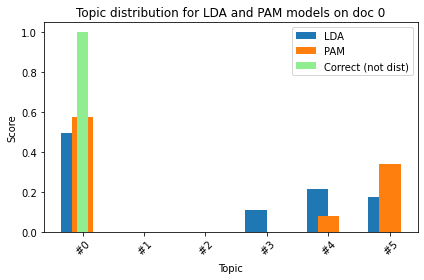

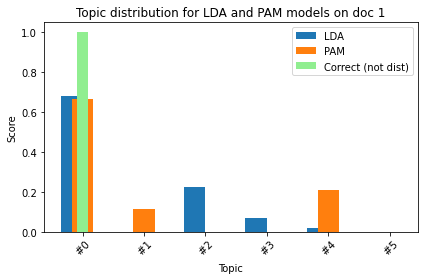

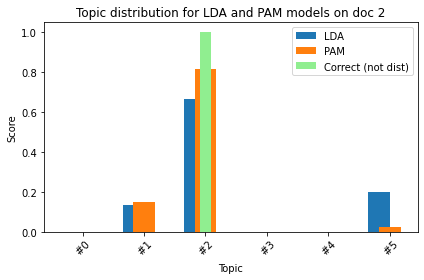

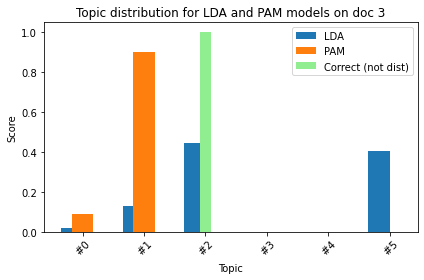

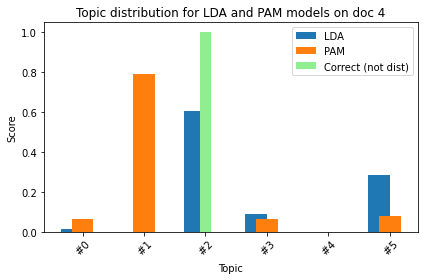

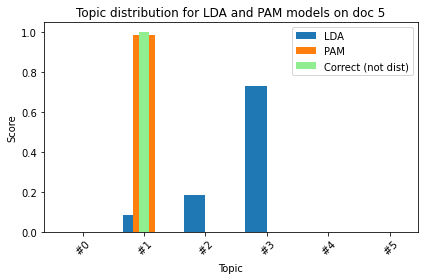

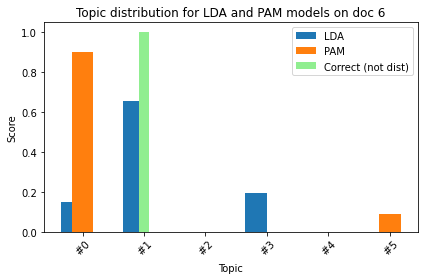

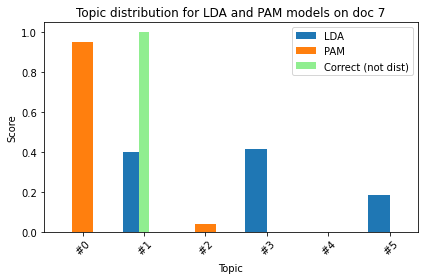

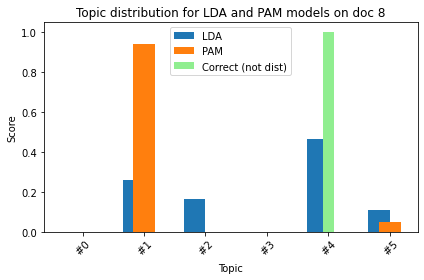

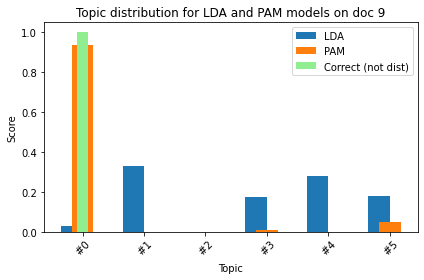

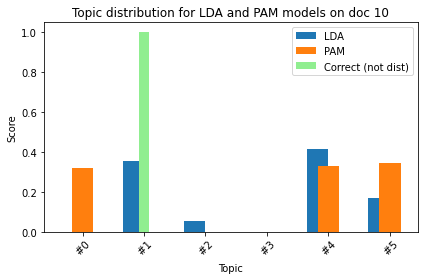

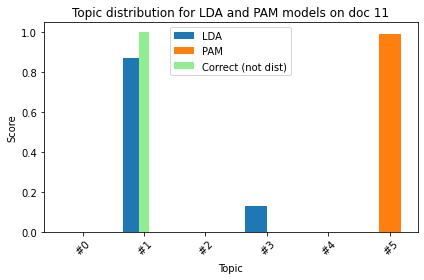

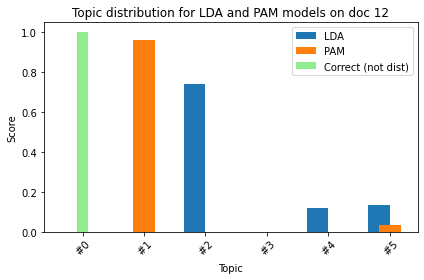

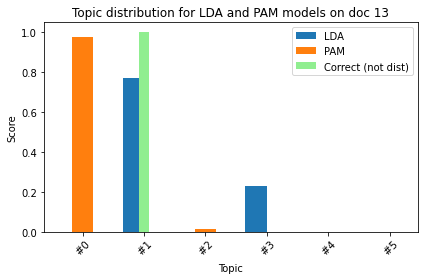

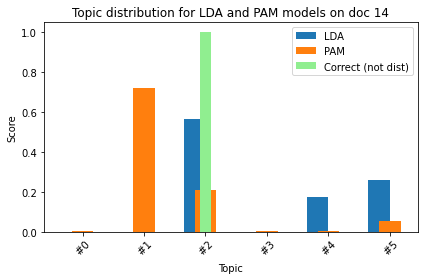

In [129]:
plot_model_doc_dists(tm_train, 15, [tm_lda, tm_pam],[lda_topic_id_converter,pam_topic_id_converter], ["LDA","PAM"])

# <div class="alert alert-block alert-info">6. Conclusion </div> <a class="anchor" id="Conclusion"></a>

In this notebook we went over the theory of 2 topic modeling techniques, the LDA and PAM. We had to observe, clean, transform and lemmatize the text inside the datasets to make use of them in our models. 
<br>
We saw and learned part of the theory behind LDA, a subject of many research papers that  and Pachinko allocation, a mixture model that uses a DAG structure to capture arbitrary topic correlations. Each leaf in the DAG is associated with a word in the vocabulary, and each interior node corresponds to a topic that models the correlation among its children, where topics can be not only parents of words, but also other topics.
<br>
Given the same dataset and respectable amount of iterations, LDA model showed better results when tested on the training dataset.

## Future work

Future plans for this notebook include `infer(doc)` method for the LDA model that will allow us to make a new distribution for a never before seen document. I will continue comparing the 2 models and believe that the Pachinko model is capable of more than what was shown in this comparison and test the models on different datasets.

# Sources

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://en.wikipedia.org/wiki/Topic_model


https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf


https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2


https://www.depends-on-the-definition.com/lda-from-scratch/


https://www.studytonight.com/advanced-data-structures/introduction-to-graphs


http://www.saf21.eu/wp-content/uploads/2018/02/Selecting-Priors-for-Latent-Dirichlet-Allocation.pdf


https://github.com/bab2min/tomotopy/blob/main/examples/lda_basic.py


https://bab2min.github.io/tomotopy/v0.12.1/en/

https://people.cs.umass.edu/~mccallum/papers/pam-icml06.pdf

https://blog.bitext.com/lemmatization-to-enhance-topic-modeling-results

https://www.datacamp.com/community/tutorials/stemming-lemmatization-python